In [1]:
# https://data-analysis-stats.jp/%E6%B7%B1%E5%B1%9E%E5%AD%A6%E7%BF%92/keras-autoencoder-%E3%81%A7%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5%E3%80%8C%E8%A9%90%E6%AC%BA%E6%A4%9C%E7%9F%A5%E3%80%8D/
# https://qiita.com/tk-tatsuro/items/10e9dbb3f2cf030e2119
!pip install lightGBM


In [2]:
from pathlib import Path
import warnings
from sklearn.svm import SVC, LinearSVC
from sklearn import multiclass
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
import scipy.stats
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# CSV„Éï„Ç°„Ç§„É´„ÇíË™≠„ÅøËæº„ÇÄ
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
print("train_data;",len(train))
print("test_data;",len(test))

train_data; 3489
test_data; 3489


In [3]:
# train„Éá„Éº„Çø„Å®test„Éá„Éº„Çø„Çí„Éü„ÉÉ„ÇØ„Çπ„Åó„Å¶„ÅÑ„Çã„ÄÇ
# ÁâπÈï∑Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞„ÇíÂà•„ÄÖ„Å´„ÇÑ„Çã„ÅÆ„ÅØÈù¢ÂÄí„Å™„ÅÆ„Åß„ÄÅ„Åì„Åì„ÅßÂêà‰Ωì„Åï„Åõ„Å¶„ÄÅÂ≠¶ÁøíÊôÇ„Å´ÂàÜ„Åë„Çã„Çà„ÅÜ„Å´„Åó„Å¶„ÅÑ„Çã„Å®ÊÄù„Çè„Çå„Çã„ÄÇË≥¢„ÅÑ„ÄÇ
def merge_train_test(df_train, df_test):
    if "ProdTaken" not in df_test.columns.tolist():
        df_test["ProdTaken"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

# Âêà‰Ωì„Åï„Åõ„Åü„Å®„Åç„Å´genre=-100„Å´„Åó„Å¶„ÅÑ„Çã„ÅÆ„Åß„ÄÅ„Åù„Çå„ÇíËµ∑ÁÇπ„Å´train„Éá„Éº„Çø„Å®test„Éá„Éº„Çø„ÇíÂàÜ„Åë„Çã„ÄÇ
def split_train_test(df):
    df_train = df[df["ProdTaken"] != -100]
    df_test = df[df["ProdTaken"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

In [4]:
# ÁâπÈï∑ÈáèÁîüÊàê

# merge_data['Count'] = 1 # Âà©Áî®ÂõûÊï∞„ÅÆÂàó„ÇíËøΩÂä†„Åó„ÄÅÂÄ§„Çí1„Å®„Åô„Çã
# daily_usage_per_customer = merge_data.groupby(['Date', 'CUSTOMER_ID'])['Count'].sum() # È°ßÂÆ¢ID„Åî„Å®„Å´Êó•‰ªò„Åî„Å®„ÅÆÂà©Áî®ÂõûÊï∞„ÇíÂêàË®à„Åó„Å¶„ÄÅ1Êó•„ÅÆÂà©Áî®ÂõûÊï∞„ÇíË®àÁÆó

# #‰∏äË®òmerge„Å®daily_usage_per_customer„ÇíÁµêÂêà
# left_DataFrame = merge_data
# right_DataFrame = daily_usage_per_customer
# merge_data = pd.merge(left_DataFrame, right_DataFrame, how='left',on=["CUSTOMER_ID","Date"], suffixes=('_x', '_total'))

# merge_data['daily_usage-mean_nb_tx_per_day'] = merge_data.apply(lambda row: row['Count_total'] - row['mean_nb_tx_per_day'], axis=1) #ÔºëÊó•„ÅÆÂà©Áî®ÂõûÊï∞ÔºçÂπ≥Âùá„ÅÆÂà©Áî®ÂõûÊï∞
# merge_data = merge_data.drop(['Count_x','Count_total'], axis=1) #'count' Âàó„ÇíÂâäÈô§
# # print(merge_data)

In [5]:
# #Ë∑ùÈõ¢Ë®àÁÆó
# #Èñ¢Êï∞‚àö(x_cus-x_ter)^2
# import numpy as np
# def func(row):
#     return np.sqrt((row['x_customer_id'] - row['x_terminal_id'])**2) + np.sqrt((row['y_customer_id'] - row['y_terminal_id'])**2)

# #‰∏äË®òÈñ¢Êï∞Èñ¢Êï∞ÂΩì„Å¶„ÅØ„ÇÅ
# merge_data['distance'] = merge_data.apply(func, axis=1)
# # print(merge_data)

In [6]:
# merge_data['TX_AMOUNT-mean'] = merge_data.apply(lambda row: row['TX_AMOUNT'] - row['mean_amount'], axis=1)
# merge_data.describe()

In [7]:
# #Á´ØÊú´„Åî„Å®„Å®Áï∞Â∏∏Áéá
# # „Éî„Éú„ÉÉ„Éà„ÉÜ„Éº„Éñ„É´„Çí‰ΩúÊàê„Åó„ÄÅË®àÁÆó
# pivot_table = pd.pivot_table(merge_data, values='TX_FRAUD', index='TERMINAL_ID',aggfunc='count')
# pivot_table_total =pivot_table.reset_index()
# # „Éî„Éú„ÉÉ„Éà„ÉÜ„Éº„Éñ„É´„Çí‰ΩúÊàê„Åó„ÄÅË®àÁÆó
# pivot_table = pd.pivot_table(merge_data, values='TX_FRAUD', index='TERMINAL_ID',aggfunc='sum')
# pivot_table_fraud =pivot_table.reset_index()
# pivot_table2 = pd.merge(pivot_table_total, pivot_table_fraud, how='left',left_on="TERMINAL_ID", right_on="TERMINAL_ID",suffixes=('_total', '_fraud'))
# pivot_table2['per_terminal'] = pivot_table2.apply(lambda row: row['TX_FRAUD_fraud'] / row['TX_FRAUD_total'], axis=1)
# pivot_table2 = pivot_table2.drop(['TX_FRAUD_total', 'TX_FRAUD_fraud'], axis=1) #'count' Âàó„ÇíÂâäÈô§
# left_DataFrame = merge_data
# right_DataFrame = pivot_table2
# merge_data = pd.merge(left_DataFrame, right_DataFrame, how='left',on='TERMINAL_ID', suffixes=('_x', '_y'))
# # print(merge_data)
# print(merge_data.columns.tolist())

In [8]:
# #È°ßÂÆ¢„Åî„Å®„ÅÆÁï∞Â∏∏Áéá
# # „Éî„Éú„ÉÉ„Éà„ÉÜ„Éº„Éñ„É´„Çí‰ΩúÊàê„Åó„ÄÅË®àÁÆó
# pivot_table = pd.pivot_table(merge_data, values='TX_FRAUD', index='CUSTOMER_ID',aggfunc='count')
# pivot_table_total =pivot_table.reset_index()
# # „Éî„Éú„ÉÉ„Éà„ÉÜ„Éº„Éñ„É´„Çí‰ΩúÊàê„Åó„ÄÅË®àÁÆó
# pivot_table = pd.pivot_table(merge_data, values='TX_FRAUD', index='CUSTOMER_ID',aggfunc='sum')
# pivot_table_fraud =pivot_table.reset_index()
# pivot_table2 = pd.merge(pivot_table_total, pivot_table_fraud, how='left',left_on="CUSTOMER_ID", right_on="CUSTOMER_ID",suffixes=('_total', '_fraud'))
# pivot_table2['per_customer'] = pivot_table2.apply(lambda row: row['TX_FRAUD_fraud'] / row['TX_FRAUD_total'], axis=1)
# pivot_table2 = pivot_table2.drop(['TX_FRAUD_total', 'TX_FRAUD_fraud'], axis=1) #'count' Âàó„ÇíÂâäÈô§
# left_DataFrame = merge_data
# right_DataFrame = pivot_table2
# merge_data = pd.merge(left_DataFrame, right_DataFrame, how='left',on='CUSTOMER_ID', suffixes=('_x', '_y'))
# # print(merge_data)
# print(merge_data.columns.tolist())

In [9]:
train.info()
# print(merge_data.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3389 non-null   object 
 2   TypeofContact           3483 non-null   object 
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3368 non-null   object 
 5   Occupation              3489 non-null   object 
 6   Gender                  3489 non-null   object 
 7   NumberOfPersonVisiting  3489 non-null   float64
 8   NumberOfFollowups       3456 non-null   float64
 9   ProductPitched          3489 non-null   object 
 10  PreferredPropertyStar   3489 non-null   float64
 11  NumberOfTrips           3467 non-null   object 
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64  
 14  Designation             3489 non-null   

In [10]:
# 0   id                      3489 non-null   int64  
#  1   Age                     3389 non-null   object 
# Âπ¥ÈΩ¢„ÄÇÊ¨†Êêç„Åó„Å¶„ÅÑ„Çã„ÄÇ„ÅÑ„ÅÑÊÑü„Åò„Å´Ë£úÂÆå„Åó„Åü„Çä„ÄÅÊ¨†ÊêçÂÄ§„ÇíÊñ∞„Åü„Å™ÁâπÈï∑Èáè„Å®„Åó„Åü„ÅÑ„ÄÇ
#  2   TypeofContact           3483 non-null   object 
# È°ßÂÆ¢„Å∏„ÅÆÈÄ£Áµ°„ÉªÊé•Ëß¶ÊñπÊ≥ï„ÄÄÁ®ÆÈ°û„Å®„ÄÅÊÑèÂë≥„ÇíÁêÜËß£„Åó„Å¶Êñ∞„Åü„Å™ÁâπÈï∑Èáè„Å´„Åß„Åç„Çã„ÅãÔºü
#  3   CityTier                3489 non-null   int64  
# È°ßÂÆ¢„ÅÆ‰Ωè„Çì„Åß„ÅÑ„ÇãÈÉΩÂ∏Ç„ÅÆ„É©„É≥„ÇØ„ÄÇ1„ÅåÊúÄÈ´ò„É©„É≥„ÇØ„ÄÇÊ¨†ÊêçÂÄ§„Å™„Åó„ÄÇ
#  4   DurationOfPitch         3368 non-null   object 
# È°ßÂÆ¢„Å∏„ÅÆ„Éó„É¨„Çº„É≥„ÉÜ„Éº„Ç∑„Éß„É≥„ÅÆÊôÇÈñì„ÄÇÊ¨†ÊêçÂÄ§„ÅÇ„Çä„ÄÇÈï∑„Åï„Å®Ê∫ÄË∂≥Â∫¶„ÄÅÊàêÁ¥ÑÁéá„ÅÆÈñ¢‰øÇÊÄß„ÇíË¶ã„Åü„ÅÑ„ÄÇ
#  5   Occupation              3489 non-null   object 
# È°ßÂÆ¢„ÅÆËÅ∑Ê•≠„ÄÇÊ¨†ÊêçÂÄ§„Å™„Åó„ÄÇËÅ∑Ê•≠„Å®ÊàêÁ¥ÑÁéá„ÅÆÈñ¢‰øÇÊÄß„ÇíË¶ã„Åü„ÅÑ„ÄÇ„ÅÇ„Å®„ÄÅ„Å©„Çì„Å™Á®ÆÈ°û„Åå„ÅÇ„Çã„ÅÆ„Åã„ÄÇ
#  6   Gender                  3489 non-null   object 
# È°ßÂÆ¢„ÅÆÊÄßÂà•
#  7   NumberOfPersonVisiting  3489 non-null   float64
# ‰∫àÂÆö„Åó„Å¶„ÅÑ„ÇãÊóÖË°å„ÅÆÂêåË°åËÄÖ„ÅÆÊï∞
#  8   NumberOfFollowups       3456 non-null   float64
# È°ßÂÆ¢„Å∏„ÅÆ„Éï„Ç©„É≠„Éº„Ç¢„ÉÉ„Éó„ÅÆÂõûÊï∞„ÄÇÊ∫ÄË∂≥Â∫¶„ÇÑÊàêÁ¥ÑÁéá„Å®„ÅÆÁõ∏Èñ¢„ÇíË¶ã„Åü„ÅÑ„ÄÇ
#  9   ProductPitched          3489 non-null   object 
# È°ßÂÆ¢„Å´ÊèêÊ°à„Åï„Çå„ÅüÂïÜÂìÅ„ÄÇÁ®ÆÈ°û„Å®„ÄÅÊàêÁ¥ÑÁéá„ÅÆÈñ¢‰øÇÊÄß„ÇíË¶ã„Åü„ÅÑ„ÄÇ
#  10  PreferredPropertyStar   3489 non-null   float64
# È°ßÂÆ¢„ÅåÂ•Ω„ÇÄ„Éõ„ÉÜ„É´„ÅÆÊòü„ÅÆÊï∞„ÄÇÊ¨†ÊêçÂÄ§„Å™„Åó„ÄÇ
#  11  NumberOfTrips           3467 non-null   object 
# È°ßÂÆ¢„ÅåÈÅéÂéª„Å´ÊóÖË°å„Åó„ÅüÂõûÊï∞„ÄÇÊ¨†ÊêçÂÄ§„ÅÇ„Çä„ÄÇÊóÖË°åÂõûÊï∞„Å®ÊàêÁ¥ÑÁéá„ÅÆÈñ¢‰øÇÊÄß„ÇíË¶ã„Åü„ÅÑ„ÄÇ
#  12  Passport                3489 non-null   int64  
# „Éë„Çπ„Éù„Éº„Éà„ÇíÊåÅ„Å£„Å¶„ÅÑ„Çã„Åã„ÄÇÊ¨†ÊêçÂÄ§„Å™„Åó„ÄÇ
#  13  PitchSatisfactionScore  3489 non-null   int64  
# „Éó„É¨„Çº„É≥„ÉÜ„Éº„Ç∑„Éß„É≥„ÅÆÊ∫ÄË∂≥Â∫¶„ÄÇÊ¨†ÊêçÂÄ§„Å™„Åó„ÄÇ
#  14  Designation             3489 non-null   object 
# È°ßÂÆ¢„ÅÆÂΩπËÅ∑„ÄÇÊ¨†ÊêçÂÄ§„Å™„Åó„ÄÇÂΩπËÅ∑„Å®ÊàêÁ¥ÑÁéá„ÅÆÈñ¢‰øÇÊÄß„ÇíË¶ã„Åü„ÅÑ„ÄÇ
#  15  MonthlyIncome           3433 non-null   object 
# È°ßÂÆ¢„ÅÆÊúàÂèé„ÄÇÊ¨†ÊêçÂÄ§„ÅÇ„Çä„ÄÇÂèéÂÖ•„Å®ÊàêÁ¥ÑÁéá„ÅÆÈñ¢‰øÇÊÄß„ÇíË¶ã„Åü„ÅÑ„ÄÇ
#  16  customer_info           3489 non-null   object 
# È°ßÂÆ¢ÊÉÖÂ†±„ÄÇÊ¨†ÊêçÂÄ§„Å™„Åó„ÄÇÊÉÖÂ†±„ÅÆÁ®ÆÈ°û„Å®„ÄÅÊàêÁ¥ÑÁéá„ÅÆÈñ¢‰øÇÊÄß„ÇíË¶ã„Åü„ÅÑ„ÄÇ
#  17  ProdTaken               3489 non-null   int64  
# ÊàêÁ¥Ñ„Åó„Åü„Åã„Å©„ÅÜ„Åã„ÄÇ0„ÅåÊú™ÊàêÁ¥Ñ„ÄÅ1„ÅåÊàêÁ¥Ñ„ÄÇÊ¨†ÊêçÂÄ§„Å™„Åó„ÄÇ


In [11]:
df = merge_train_test(train, test)
df.isnull().sum()


id                          0
Age                       193
TypeofContact              18
CityTier                    0
DurationOfPitch           252
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups          57
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips              64
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome             105
customer_info               0
ProdTaken                   0
dtype: int64

In [12]:
# „Åù„Çå„Åû„Çå„ÅÆÁâπÂæ¥Èáè„ÅÆ„É¶„Éã„Éº„ÇØ„ÇíÂèØË¶ñÂåñ„Åó„ÄÅÁâπÂæ¥Èáè„ÇíÂâçÂá¶ÁêÜ„Åô„Çã
# df["Age"].unique()
# ÂÖ•Âäõ„Åå„Éê„É©„Éê„É©„Å™„ÅÆ„Åß„ÄÅÊï∞ÂÄ§„Å´Â§âÊèõ„Åô„Çã
# „Åô„Åπ„Å¶„ÅÆÂπ¥ÈΩ¢„Å´Ê≠≥„Åå„Å§„ÅÑ„Å¶„ÅÑ„Çã„ÅÆ„Åß„ÄÅÊúÄÂæå„ÅÆ‰ΩçÁΩÆÊñáÂ≠ó„ÇíÂèñ„ÇäÈô§„Åè
df["Age"] = df["Age"].str[:-1]
# ÂçäËßíÊï∞Â≠ó„ÄÅnan„ÅØ„Åù„ÅÆ„Åæ„Åæ„Å®„Åó„Å¶„ÄÅÂÖ®ËßíÊï∞Â≠ó„Å†„Å£„ÅüÂ†¥ÂêàÂçäËßíÊï∞Â≠ó„Å´Â§âÊèõ„Åô„Çã„ÄÇÊº¢Â≠ó„ÅÆÊï∞Â≠ó„ÅØÂ§âÊèõ„Åß„Åç„Å™„ÅÑ„ÅÆ„Åß„Åù„ÅÆ„Åæ„Åæ„Å®„Åô„Çã„ÄÇ
# ÂÖ®ËßíÊï∞Â≠ó„ÇíÂçäËßíÊï∞Â≠ó„Å´Â§âÊèõ„Åô„ÇãÈñ¢Êï∞
def zenkaku_to_hankaku(s):
    return s.translate(str.maketrans('ÔºêÔºëÔºíÔºìÔºîÔºïÔºñÔºóÔºòÔºô', '0123456789'))

# ÂÖ®ËßíÊº¢Êï∞Â≠ó„ÇíÂçäËßíÊï∞Â≠ó„Å´Â§âÊèõ„Åô„ÇãÈñ¢Êï∞
kanji_to_num = {
    '‰∏Ä': '1', '‰∫å': '2', '‰∏â': '3', 'Âõõ': '4', '‰∫î': '5',
    'ÂÖ≠': '6', '‰∏É': '7', 'ÂÖ´': '8', '‰πù': '9', '„Äá': '0',
    'ÂçÅ': '10', 'Áôæ': '100', 'ÂçÉ': '1000'
}

def kanji_to_hankaku(s):
    num = 0
    unit = 1
    temp = 0
    for char in s:
        if char in kanji_to_num:
            digit = kanji_to_num[char]
            # digit„ÅØÊñáÂ≠óÂàó„Å™„ÅÆ„Åß„ÄÅint„Å´Â§âÊèõ„Åô„Çã
            digit = int(digit)
            if digit >= 10:
                if temp == 0:
                    temp = 1
                num += temp * digit
                temp = 0
            else:
                temp = temp * 10 + digit
        else:
            return s  # Êº¢Êï∞Â≠ó‰ª•Â§ñ„ÅÆÊñáÂ≠ó„ÅåÂê´„Åæ„Çå„Å¶„ÅÑ„ÇãÂ†¥Âêà„ÅØÂ§âÊèõ„Åó„Å™„ÅÑ
    num += temp
    return str(num)

# Â§âÊèõ„ÇíÈÅ©Áî®„Åô„ÇãÈñ¢Êï∞
def convert_age(age):
    if pd.isna(age):
        return age
    age = str(age)
    age = zenkaku_to_hankaku(age)
    age = kanji_to_hankaku(age)
    try:
        return int(age)
    except ValueError:
        return age

# Â§âÊèõ„ÇíÈÅ©Áî®
df['Age'] = df['Age'].apply(convert_age)

df["Age"]


0       50.0
1       56.0
2        NaN
3       37.0
4       48.0
        ... 
6973    41.0
6974    44.0
6975    24.0
6976    25.0
6977    44.0
Name: Age, Length: 6978, dtype: float64

In [13]:
df["customer_info"].unique()

array(['Êú™Â©ö ËªäÊú™ÊâÄÊåÅ Â≠ê‰æõ„Å™„Åó', 'Èõ¢Â©öÊ∏à„Åø,Ëªä„ÅÇ„Çä,Â≠ê‰æõÁÑ°„Åó', 'ÁµêÂ©öÊ∏à„Åø„ÄÅËá™ÂãïËªäÊú™ÊâÄÊúâ,Â≠ê‰æõ„Å™„Åó', ...,
       'Èõ¢Â©öÊ∏à„ÅøÔºèËªä‰øùÊúâÔºèÂ≠ê‰æõÊúâ„Çä(1‰∫∫)', 'ÁµêÂ©öÊ∏à„Åø\tËªäÊú™ÊâÄÊåÅ\tÂ≠ê‰æõÊúâ„Çä 3‰∫∫',
       'Êú™Â©ö\u3000Ëªä„Å™„Åó\u3000Â≠ê‰æõ3‰∫∫'], dtype=object)

In [14]:
# NumberOfTrips„ÅÆÂâçÂá¶ÁêÜ„ÄÇ
# Â§âÊèõ„Éû„ÉÉ„Éî„É≥„Ç∞„Çí‰ΩúÊàê
mapping = {
    'Âπ¥„Å´1Âõû': 1,
    'Âπ¥„Å´2Âõû': 2,
    'Âπ¥„Å´3Âõû': 3,
    'Âπ¥„Å´4Âõû': 4,
    'Âπ¥„Å´5Âõû': 5,
    'Âπ¥„Å´6Âõû': 6,
    'Âπ¥„Å´7Âõû': 7,
    'Âπ¥„Å´8Âõû': 8,
    'ÂçäÂπ¥„Å´1Âõû': 2,  # ÂçäÂπ¥„Å´1Âõû„ÅØÂπ¥„Å´2Âõû
    'ÂõõÂçäÊúü„Å´1Âõû': 4  # ÂõõÂçäÊúü„Å´1Âõû„ÅØÂπ¥„Å´4Âõû
}

# Â§âÊèõÈñ¢Êï∞„ÇíÂÆöÁæ©
def convert_trips(value):
    if pd.isna(value):
        return np.nan
    if value in mapping:
        return mapping[value]
    try:
        return int(value)
    except ValueError:
        return np.nan
# Â§âÊèõ„ÇíÈÅ©Áî®
df["NumberOfTrips"] = df["NumberOfTrips"].apply(convert_trips)
df["NumberOfTrips"].unique()
df["NumberOfPersonVisiting"].unique()



array([1., 2., 3., 4.])

In [15]:
# DurationOfPitch„ÅÆÂâçÂá¶ÁêÜ„ÄÇÁßí„Å´Â§âÊèõ„Åô„Çã„ÄÇ
df["DurationOfPitch"].unique()
# Áßí„ÅÆ„ÇÇ„ÅÆ„ÅØÁßí„Åæ„Åß„ÇíÂèñ„ÇäÂá∫„Åô„ÄÇÂàÜ„ÅÆ„ÇÇ„ÅÆ„ÅØÁßí„Å´Â§âÊèõ„Åô„Çã„ÄÇ
def convert_duration(duration):
    if pd.isna(duration):
        return duration
    duration = str(duration)
    if "Áßí" in duration:
        # Áßí„ÅÆ„ÇÇ„ÅÆ„ÅØÁßí„Åæ„Åß„ÇíÂèñ„ÇäÂá∫„Åô
        return int(duration[:-1])
    if "ÂàÜ" in duration:
        return int(duration[:-1]) * 60
    return duration

df["DurationOfPitch"] = df["DurationOfPitch"].apply(convert_duration)
df["DurationOfPitch"]

0        900.0
1        840.0
2        600.0
3       1080.0
4       1020.0
         ...  
6973     840.0
6974    2100.0
6975    1260.0
6976     540.0
6977     480.0
Name: DurationOfPitch, Length: 6978, dtype: float64

In [16]:
# Âπ¥ÈΩ¢„ÅÆÂá¶ÁêÜ„ÄÇÁî∑ÊÄß„Åå1„ÄÅÂ•≥ÊÄß„Åå0„Å´Â§âÊèõ„Åô„Çã„ÄÇ
df["Gender"].unique()
# m„ÄÅM„ÄÅÔΩç„ÄÅÔº≠„ÇíÁî∑ÊÄß„Å´„ÄÅf„ÄÅF„ÄÅÔΩÜ„ÄÅÔº¶„ÇíÂ•≥ÊÄß„Å´Â§âÊèõ„Åô„Çã„ÄÇ
# ÊñáÂ≠óÂàó„ÅåÂÖ®Ëßí„Å†„Å£„Åü„ÇâÂçäËßí„Å´Â§âÊèõ„Åô„Çã„ÄÇ
def zenkaku_to_hankaku(s):
    return s.translate(str.maketrans('ÔΩçÔΩÜÔº≠Ôº¶MF', 'mfmfmf'))

def gender_to_int(s):
    num = 0
    unit = 1
    temp = 0
    for char in s:
        if char == "m":
            return 1
        if char == "f":
            return 0
        return s
    return str(num)

# Â§âÊèõ„ÇíÈÅ©Áî®„Åô„ÇãÈñ¢Êï∞
def convert_gender(gender):
    if pd.isna(gender):
        return gender
    gender = str(gender)
    gender = zenkaku_to_hankaku(gender)
    gender = gender_to_int(gender)
    try:
        return int(gender)
    except ValueError:
        return gender
    
df["Gender"] = df["Gender"].apply(convert_gender)
# ÊúÄÂàù„ÅÆÊñáÂ≠ó„Ååm„Å†„Å£„Åü„Çâ1„ÄÅf„Å†„Å£„Åü„Çâ0„Å´Â§âÊèõ„Åô„Çã„ÄÇ

df["Gender"].head()


def zenkaku_to_hankaku_pp(s):
    zenkaku = 'Ôº°Ôº¢Ôº£Ôº§Ôº•Ôº¶ÔºßÔº®Ôº©Ôº™Ôº´Ôº¨Ôº≠ÔºÆÔºØÔº∞Ôº±Ôº≤Ôº≥Ôº¥ÔºµÔº∂Ôº∑Ôº∏ÔºπÔº∫ÔΩÅÔΩÇÔΩÉÔΩÑÔΩÖÔΩÜÔΩáÔΩàÔΩâÔΩäÔΩãÔΩåÔΩçÔΩéÔΩèÔΩêÔΩëÔΩíÔΩìÔΩîÔΩïÔΩñÔΩóÔΩòÔΩôÔΩöÔºêÔºëÔºíÔºìÔºîÔºïÔºñÔºóÔºòÔºô'
    hankaku = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789'
    table = str.maketrans(zenkaku, hankaku)
    
    return s.translate(str.maketrans(table))

def pp_to_int(s):
    if s[0] == "b":
        re= 0
    elif s[0] == "s":
        re= 1
    elif s[0] == "d":
        re = 2
    elif s[0] == "k":
        re = 3
    elif s[0] == "B":
        re = 0
    elif s[0] == "S":
        re = 1
    elif s[0] == "D":
        re = 2
    elif s[0] == "K":
        re = 3
    elif s[0] == "·óû":
        re = 2
    elif s[0] == "·é†":
        re = 2
    elif s[0] == "–í":
        re = 0
    elif s[0] == "Íì¢":
        re = 1
    elif "Œí" in s:
        re = 0
    elif "êä°" in s:
        re = 0
    elif "–Ö" in s:
        re = 1
    elif "’è" in s:
        re = 1
    elif "ùô≥" in s:
        re = 2
    else:
        print(s[0])
        re = -100
    return re

def designation_to_int(s):
    if "E" == s[0]:
        re = 0
    elif "S" == s[0]:
        re = 1
    elif "–Ö" == s[0]:
        re = 1
    elif "’èenior" in s:
        re = 1
    elif "A" == s[0]:
        re = 2
    elif "–ê" in s:
        re = 2
    elif "M" == s[0]:
        re = 3
    elif "Œú" == s[0]:
        re = 3
    elif "V" == s[0]:
        re = 4
    elif "–ï" == s[0]:
        re = 0
    elif "ŒëVP" in s:
        re = 2    

    else:
        print(s)
        re = -100
    return re

# Â§âÊèõ„ÇíÈÅ©Áî®„Åô„ÇãÈñ¢Êï∞
def convert_pp(pp):
    if pd.isna(pp):
        return pp
    pp = str(pp)
    pp = zenkaku_to_hankaku_pp(pp)
    pp = pp_to_int(pp)
    try:
        return int(pp)
    except ValueError:
        return pp
df["ProductPitched"] = df["ProductPitched"].apply(convert_pp)
df["ProductPitched"].unique()
# 0„ÅåBasic„ÄÅ1„ÅåStandard„ÄÅ2„ÅåDeluxe„ÄÅ3„ÅåKing

def convert_designation(designation):
    if pd.isna(designation):
        return designation
    designation = str(designation)
    designation = zenkaku_to_hankaku_pp(designation)
    designation = designation_to_int(designation)
    try:
        return int(designation)
    except ValueError:
        return designation
    
# Exective:0, Senior Manager:1, AVP:2, Manager:3„ÄÅVP:4
df["Designation"] = df["Designation"].apply(convert_designation)
df["Designation"].unique()
    

array([0, 1, 2, 3, 4])

In [17]:
# MonthlyIncome
def convert_monthincome(monthincome):
    if pd.isna(monthincome):
        return monthincome
    monthincome = str(monthincome)
    if "Êúà" in monthincome:
        # ÊúàÂèé‰∏áÂÜÜ„ÇíÁúÅÁï•
        monthincome = monthincome[2:-2]
        monthincome = float(monthincome)  * 10000
    try:
        return float(monthincome)
    except ValueError:
        return monthincome
    
# Exective:0, Senior Manager:1, AVP:2, Manager:3„ÄÅVP:4
df["MonthlyIncome"] = df["MonthlyIncome"].apply(convert_monthincome)
df["MonthlyIncome"].describe()

count      6873.000000
mean     356131.710316
std       76149.009367
min      200000.000000
25%      300000.000000
50%      342075.000000
75%      400000.000000
max      600000.000000
Name: MonthlyIncome, dtype: float64

In [18]:
# customer_info
import re
    
def classification(customer_info):
    print(customer_info)
    if "Êú™Â©ö" in str(customer_info[0]):
        married = 0
    elif "Áã¨Ë∫´" in str(customer_info[0]):
        married = 0
    elif "Èõ¢Â©ö" in str(customer_info[0]):
        married = 2
    elif "ÁµêÂ©ö" in str(customer_info[0]):
        married = 1
    else:
        print(customer_info[0])

    if "ËªäÊú™ÊâÄÊåÅ" in str(customer_info[1]):
        has_car = 0
    elif "Êú™ÊâÄÊúâ" in str(customer_info[1]):
        has_car = 0
    elif "‰πóÁî®Ëªä„Å™„Åó" in str(customer_info[1]):
        has_car = 0
    elif "Ëá™ÂÆ∂Áî®Ëªä„Å™„Åó" in str(customer_info[1]):
        has_car = 0
    elif "Ëªä„Å™„Åó" in str(customer_info[1]):
        has_car = 0
    elif "Ëªä„ÅÇ„Çä" in str(customer_info[1]):
        has_car = 1
    elif "ËªäÊâÄÊåÅ" in str(customer_info[1]):
        has_car = 1
    elif "Ëªä‰øùÊúâ" in str(customer_info[1]):
        has_car = 1
    elif "Ëá™ÂãïËªäÊâÄÊúâ" in str(customer_info[1]):
        has_car = 1
    else:
        print(customer_info[1])



    if "„Å™„Åó" in str(customer_info[2]):
        has_child = 0
    elif "ÁÑ°„Åó" in str(customer_info[2]):
        has_child = 0
    elif "ÁÑ°Â≠ê" in str(customer_info[2]):
        has_child = 0
    elif "Â≠ê‰æõ„Çº„É≠" in str(customer_info[2]):
        has_child = 0
        #ÈùûËÇ≤ÂÖêÂÆ∂Â∫≠„ÅØÂà•„ÅÆÂ§âÊï∞„Å´„Åô„Çã„ÅÆ„ÇÇ„ÅÇ„ÇäÔºüÔºü
    elif "ÈùûËÇ≤ÂÖêÂÆ∂Â∫≠" in str(customer_info[2]):
        has_child = 0
    elif "Â≠êËÇ≤„Å¶Áä∂Ê≥Å‰∏çÊòé" in str(customer_info[2]):
        has_child = -1
    elif "Â≠ê„ÅÆÊï∞‰∏çË©≥" in str(customer_info[2]):
        has_child = -1
    elif "Â≠ê‰æõ„ÅÆÊï∞‰∏çÊòé" in str(customer_info[2]):
        has_child = -1
    elif "„Çè„Åã„Çâ„Å™„ÅÑ" in str(customer_info[2]):
        has_child = -1
    elif "‰∏çÊòé" in str(customer_info[2]):
        has_child = -1
    elif "„Åì„Å©„ÇÇ1‰∫∫" in str(customer_info[2]):
        has_child = 1
    elif "1ÂÖê" in str(customer_info[2]):
        has_child = 1
    elif "Â≠ê‰æõ1‰∫∫" in str(customer_info[2]):
        has_child = 1
    elif "Â≠ê‰æõÊúâ„Çä(1‰∫∫)" in str(customer_info[2]):
        has_child = 1
    elif "Â≠ê‰æõÊúâ„Çä" in str(customer_info[2]):
        has_child = 1
    elif "„Åì„Å©„ÇÇ2‰∫∫" in str(customer_info[2]):
        has_child = 2
    elif "Â≠ê‰æõ2‰∫∫" in str(customer_info[2]):
        has_child = 2
    elif "2ÂÖê" in str(customer_info[2]):
        has_child = 2
    elif "„Åì„Å©„ÇÇ3‰∫∫" in str(customer_info[2]):
        has_child = 2
    elif "Â≠ê‰æõ3‰∫∫" in str(customer_info[2]):
        has_child = 3
    elif "3ÂÖê" in str(customer_info[2]):
        has_child = 3
    else:
        print(customer_info[2])


    return married, has_car, has_child


def split(text):
    # „Ç´„É≥„Éû„ÅßÂõ≤„Åæ„Çå„Å¶„ÅÑ„ÇãÂ†¥Âêà„ÅØÂâäÈô§„Åô„Çã

    if (text.startswith("'") and text.endswith("'")) or (text.startswith('"') and text.endswith('"')):
        text = text[1:-1]
    text = re.sub(r"^['\"]|['\"]$", '', text)
    # Âæó„Çâ„Çå„ÅüÊñáÂ≠óÂàó„Çí„Ç´„É≥„Éû„ÄÅÂÖ®Ëßí„Ç´„É≥„Éû„ÄÅ„Çπ„Éö„Éº„Çπ„ÄÅÂÖ®Ëßí„Çπ„Éö„Éº„Çπ„ÅßÂàÜÂâ≤„Åô„Çã
    text = re.split(r',|„ÄÅ| |„ÄÄ|Ôºè|/|\t|\n', text)
    # print(text)
    return text
    



# Â§âÊèõ„ÇíÈÅ©Áî®„Åô„ÇãÈñ¢Êï∞
def convert_customer_info(customer_info):
    if pd.isna(customer_info):
        return customer_info
    customer_info = str(customer_info)
    customer_info = split(customer_info)
    married, has_car, has_child = classification(customer_info)
    try:
        return int(married),int(has_car), int(has_child)
    except ValueError:
        return married, has_car, has_child
    
df["customer_info"] = df["customer_info"].apply(convert_customer_info)
# ÊúÄÂàù„ÅÆÊñáÂ≠ó„Ååm„Å†„Å£„Åü„Çâ1„ÄÅf„Å†„Å£„Åü„Çâ0„Å´Â§âÊèõ„Åô„Çã„ÄÇ

# df["customer_info"]„ÅÆ„ÅÜ„Å°ÊúÄÂàù„ÅÆË¶ÅÁ¥†„ÇíÂèñ„ÇäÂá∫„Åó„Å¶Êñ∞„Åü„Å™ÁâπÈï∑Èáè„Å®„Åô„Çã„ÄÇ
df["customer_info_marry"] = df["customer_info"].apply(lambda x: x[0])
df["customer_info_has_car"] = df["customer_info"].apply(lambda x: x[1])
df["customer_info_has_child"] = df["customer_info"].apply(lambda x: x[2])

df["customer_info_marry"].unique()


['Êú™Â©ö', 'ËªäÊú™ÊâÄÊåÅ', 'Â≠ê‰æõ„Å™„Åó']
['Èõ¢Â©öÊ∏à„Åø', 'Ëªä„ÅÇ„Çä', 'Â≠ê‰æõÁÑ°„Åó']
['ÁµêÂ©öÊ∏à„Åø', 'Ëá™ÂãïËªäÊú™ÊâÄÊúâ', 'Â≠ê‰æõ„Å™„Åó']
['Èõ¢Â©öÊ∏à„Åø', 'ËªäÊâÄÊåÅ', 'Â≠ê‰æõÁÑ°„Åó']
['Áã¨Ë∫´', 'ËªäÊâÄÊåÅ', 'ÁÑ°Â≠ê']
['Áã¨Ë∫´', 'ËªäÊú™ÊâÄÊåÅ', 'Â≠ê‰æõ„Çº„É≠']
['Áã¨Ë∫´', 'Ëá™ÂÆ∂Áî®Ëªä„ÅÇ„Çä', 'Â≠ê‰æõ„Å™„Åó']
['ÁµêÂ©öÊ∏à„Åø', 'ËªäÊú™ÊâÄÊåÅ', 'Â≠ê‰æõ„Å™„Åó']
['Áã¨Ë∫´', 'ËªäÊú™ÊâÄÊåÅ', 'Â≠ê‰æõÁÑ°„Åó']
['ÁµêÂ©öÊ∏à„Åø', 'ËªäÊâÄÊåÅ', 'ÈùûËÇ≤ÂÖêÂÆ∂Â∫≠']
['Êú™Â©ö', 'Ëªä‰øùÊúâ', 'Â≠ê‰æõ„Å™„Åó']
['Èõ¢Â©öÊ∏à„Åø', 'Ëªä„ÅÇ„Çä', 'Â≠ê‰æõ„Å™„Åó']
['Áã¨Ë∫´', 'ËªäÊâÄÊåÅ', 'Â≠ê‰æõ„Å™„Åó']
['ÁµêÂ©öÊ∏à„Åø', 'ËªäÊâÄÊåÅ', 'ÈùûËÇ≤ÂÖêÂÆ∂Â∫≠']
['Áã¨Ë∫´', 'ËªäÊâÄÊåÅ', 'ÁÑ°Â≠ê']
['Áã¨Ë∫´', 'ËªäÊâÄÊåÅ', 'Â≠ê‰æõ„Å™„Åó']
['Áã¨Ë∫´', 'ËªäÊú™ÊâÄÊåÅ', 'Â≠ê‰æõ„Å™„Åó']
['Êú™Â©ö', 'ËªäÊâÄÊåÅ', 'Â≠ê‰æõÁÑ°„Åó']
['ÁµêÂ©öÊ∏à„Åø', 'Ëá™ÂãïËªäÊú™ÊâÄÊúâ', 'Â≠ê‰æõÁÑ°„Åó']
['ÁµêÂ©öÊ∏à„Åø', 'Ëá™ÂãïËªäÊú™ÊâÄÊúâ', 'Â≠ê‰æõ„Å™„Åó']
['Êú™Â©ö', 'Ëªä‰øùÊúâ„Å™„Åó', 'Â≠ê‰æõ„Å™„Åó']
['Èõ¢Â©öÊ∏à„Åø', '‰πóÁî®ËªäÊâÄÊåÅ', 'Â≠ê‰æõ„Å™„Åó']
['È

array([0, 2, 1])

In [19]:


columns_label_enc = ["TypeofContact","Occupation","CityTier","NumberOfPersonVisiting"]
for col in columns_label_enc:
    # region„ÅÆ„É©„Éô„É´„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„ÇíË°å„Å£„Å¶„ÅÑ„Çã„ÄÇ
    # „É©„Éô„É´„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„Å®„ÅØ„ÄÅ„Ç´„ÉÜ„Ç¥„É™Â§âÊï∞„ÇíÊï∞ÂÄ§„Å´Â§âÊèõ„Åô„Çã„Åì„Å®„ÄÇ„ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„Å®ÈÅï„ÅÑ„ÄÅÊï∞ÂÄ§„ÅåÂ§ßÂ∞èÈñ¢‰øÇ„ÇíÊåÅ„Å§„Åü„ÇÅ„ÄÅ„É¢„Éá„É´„ÅåÂ§ßÂ∞èÈñ¢‰øÇ„ÇíÂ≠¶Áøí„Åß„Åç„Çã„ÄÇ„Å©„Å°„Çâ„Åã„ÇíÊé°Áî®„Åô„Çã„Åì„Å®„ÄÇ
    df[col] = LabelEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, col] = np.nan
df["CityTier"].unique()


array([1., 0., 2.])

In [20]:
df["num_nans"] = 0
for col in [
    "Age",
    "TypeofContact",
    "DurationOfPitch",
    "NumberOfFollowups",
    "NumberOfTrips",
    "MonthlyIncome",
]:
    df["num_nans"] += df[col].isna()

In [21]:
# ‰ªäÂõû„ÅØÊ¨†ÊêçÂÄ§„ÅåÂ§ö„ÅÑ„ÅÆ„Åß„ÄÅÊ¨†ÊêçÂÄ§„ÅÆÂàó„ÇíÁõÆÁöÑÂ§âÊï∞„Å®„Åó„Å¶„ÄÅÊ¨†ÊêçÂÄ§„ÅÆÂÄ§„Çí‰∫àÊ∏¨„Åô„Çã„É¢„Éá„É´„Çí‰ΩúÊàê„Åô„Çã„ÄÇ

df.isnull().sum()
# null„Åå„ÅÇ„Çãcolumn„ÇíÂèñÂæó„Åô„Çã
null_columns = df.columns[df.isnull().sum() > 0]
print(null_columns)
null_columns = ['Age',"DurationOfPitch","NumberOfFollowups","NumberOfTrips","MonthlyIncome",
                'TypeofContact','NumberOfPersonVisiting','ProductPitched','PreferredPropertyStar','Designation',]

features = ["Age","TypeofContact","DurationOfPitch","Gender","NumberOfFollowups","NumberOfTrips","PitchSatisfactionScore","MonthlyIncome","Passport",
            "Designation","PreferredPropertyStar","customer_info_marry","customer_info_has_car","customer_info_has_child",
            "num_nans","NumberOfPersonVisiting","ProductPitched","CityTier","Occupation",
            ]
# Â≠¶Áøí„Å´Áî®„ÅÑ„Å™„ÅÑ„Éá„Éº„Çø
not_features = ["id","ProdTaken","customer_info"]


for null_column in null_columns:
    # Ê¨†ÊêçÂÄ§„Çí‰∫àÊ∏¨„Åô„Çã„É¢„Éá„É´„Çí‰ΩúÊàê„Åô„Çã„ÄÇ„ÉÜ„Çπ„Éà„Éá„Éº„Çø„ÅØ‰ΩøÁî®„Åó„Å™„ÅÑ„Çà„ÅÜ„Å´„Åô„Çã„ÄÇ
    train_data, test_data = split_train_test(df)
    # Ê¨†ÊêçÂÄ§„ÅÆË°å„ÇíÂèñ„ÇäÂá∫„Åô„ÄÇÊ¨†ÊêçÂÄ§„Åå„Å™„ÅÑÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó
    if len(train_data[train_data[null_column].isnull()]) == 0:
        continue
    null_data = train_data[train_data[null_column].isnull()]
    # Ê¨†ÊêçÂÄ§„ÅÆ„Å™„ÅÑË°å„ÇíÂ≠¶Áøí„Éá„Éº„Çø„Å®„Åó„Å¶Âèñ„ÇäÂá∫„Åô
    train_data_non_null = train_data.dropna(subset=[null_column])

    # features„ÅÆÁâπÈï∑Èáè„Å´ÈôêÂÆö„Åô„Çã
    train_data_non_null = train_data_non_null[features]
    null_data = null_data[features]


    # Ê¨†ÊêçÂÄ§„Çí‰∫àÊ∏¨„Åô„Çã„É¢„Éá„É´„Çílightgbm„Åß‰ΩúÊàê„Åô„Çã
    # „É¢„Éá„É´„ÅÆ‰ΩúÊàê
    model = lgb.LGBMRegressor()
    # ÁâπÂæ¥Èáè„Å®ÁõÆÁöÑÂ§âÊï∞„ÇíÂèñ„ÇäÂá∫„Åô
    X = train_data_non_null.drop(columns=null_column)
    y = train_data_non_null[null_column]
    # Â≠¶Áøí
    model.fit(X, y)
    # ‰∫àÊ∏¨
    pred = model.predict(null_data.drop(columns=null_column))
    # null_data„Å´‰∫àÊ∏¨ÁµêÊûú„Çí‰ª£ÂÖ•„Åó„ÄÅtrain_data_non_null„Å®Âêà„Çè„Åõ„Å¶ÂÖÉ„ÅÆtrain_data„Å´Êàª„Åô„ÄÇ
    null_data.loc[:, null_column] = pred
    # train_data_non_null„ÅÆnot_features„Çí‰ªò„ÅëË∂≥„Åô
    train_data_non_null = train_data_non_null.join(train_data[not_features])
    # null_data„ÅÆnot_features„Çí‰ªò„ÅëË∂≥„Åô
    null_data = null_data.join(train_data[not_features])
    train_data = pd.concat([train_data_non_null, null_data]).reset_index(drop=True)

    # test_data„Åß„ÇÇÂêåÊßò„Å´‰∫àÊ∏¨„Åó„Å¶‰∫àÊ∏¨ÂÄ§„Çí‰ª£ÂÖ•„Åô„Çã
    pred = model.predict(test_data[features].drop(columns=null_column))
    test_data.loc[:, null_column] = pred

    # df„Å´train_data„Å®test_data„ÇíÁµêÂêà„Åô„Çã
    df = pd.concat([train_data, test_data]).reset_index(drop=True)

# df„Å´nan„Åå„ÅÇ„Çã„ÅãÁ¢∫Ë™ç„Åô„Çã
print(df.columns[df.isnull().sum() > 0])
# nan„Åå„ÅÇ„Çã„ÇÇ„ÅÆ„ÇíÊäΩÂá∫„Åó„Å¶Âá∫Âäõ„Åô„Çã
null_data = df[df.isnull().sum(axis=1) > 0]
print(null_data)



Index(['Age', 'DurationOfPitch', 'NumberOfFollowups', 'NumberOfTrips',
       'MonthlyIncome'],
      dtype='object')
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 3389, number of used features: 18
[LightGBM] [Info] Start training from score 38.889938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 3368, number of used features: 18
[LightGBM] [Info] Start training from score 860.682898
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead 

In [22]:
# TypeofContact„ÅÆone-hot„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„ÄÅ„Å§„ÅÑ„Åß„Å´unknown„ÅÆÂàóÂêç„ÇíÂ§âÊõ¥„Åó„Å¶„ÅÑ„Çã„ÄÇ
df = pd.concat([df, pd.get_dummies(df["TypeofContact"]).astype(int).rename(columns={np.nan: "TypeofContact_nan"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["Occupation"]).astype(int).rename(columns={np.nan: "Occupation_nan"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["CityTier"]).astype(int).rename(columns={1: "CityTier_1", 2: "CityTier_2", 0: "CityTier_3"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["NumberOfPersonVisiting"]).astype(int).rename(columns={1: "NumberOfPersonVisiting_1", 2: "NumberOfPersonVisiting_2", 3: "NumberOfPersonVisiting_3", 0: "NumberOfPersonVisiting_4"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["ProductPitched"]).astype(int).rename(columns={0: "ProductPitched_0", 1: "ProductPitched_1", 2: "ProductPitched_2", 3: "ProductPitched_3"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["PreferredPropertyStar"]).astype(int).rename(columns={3: "PreferredPropertyStar_3", 4: "PreferredPropertyStar_4", 5: "PreferredPropertyStar_5"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["Passport"]).astype(int)], axis=1).rename(columns={0: "Passport_0", 1: "Passport_1"})
df = pd.concat([df, pd.get_dummies(df["Designation"]).astype(int).rename(columns={0: "Designation_0", 1: "Designation_1", 2: "Designation_2", 3: "Designation_3", 4: "Designation_4"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["customer_info_marry"]).astype(int).rename(columns={0: "customer_info_marry_0", 1: "customer_info_marry_1", 2: "customer_info_marry_2"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["customer_info_has_car"]).astype(int).rename(columns={0: "customer_info_has_car_0", 1: "customer_info_has_car_1"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["customer_info_has_child"]).astype(int).rename(columns={0: "customer_info_has_child_0", 1: "customer_info_has_child_1", 2: "customer_info_has_child_2", 3: "customer_info_has_child_3", -1: "customer_info_has_child_-1"})], axis=1)
# TypeofContact„ÅØ2ÂÄ§„Åó„Åã„Å™„ÅÑ„ÅÆ„Åß„Ç´„Ç¶„É≥„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„Å´„ÅØÂêë„Åã„Å™„ÅÑ„ÄÇ


class CountEncoder:
    def fit(self, series):
        # "series"„Åî„Å®„ÅÆÂá∫ÁèæÂõûÊï∞„Çí„Ç´„Ç¶„É≥„Éà
        self.counts = series.groupby(series).count()
        return self

    def transform(self, series):
        # "series"„ÅÆÂêÑË¶ÅÁ¥†„Çí„ÄÅfitÊôÇ„Å´ÈõÜË®à„Åó„ÅüÂá∫ÁèæÂõûÊï∞„Å´ÁΩÆÊèõ
        return series.map(self.counts).fillna(0)

    def fit_transform(self, series):
        # fit„Å®transform„Çí„Åæ„Å®„ÇÅ„Å¶ÂÆüË°å
        return self.fit(series).transform(series)
columns_count_enc = ["CityTier","NumberOfPersonVisiting","NumberOfFollowups","ProductPitched","NumberOfTrips","Passport","PitchSatisfactionScore","Designation","customer_info_marry","customer_info_has_car","customer_info_has_child"]
for col in columns_count_enc:
    # region„ÅÆÂá∫ÁèæÂõûÊï∞„Çí„Ç´„Ç¶„É≥„Éà„Åó„Å¶„ÄÅÊñ∞„Åó„ÅÑÂàó„Çí‰ΩúÊàê„Åó„Å¶„ÅÑ„Çã„ÄÇ
    df["countenc_" + col] = CountEncoder().fit_transform(df[col])
    # Ê¨†ÊêçÂÄ§„Çínan„Å´Â§âÊèõ„Åó„Å¶„ÅÑ„Çã„ÄÇloc„ÅØnan„ÅÆË°å„ÇíÂèñÂæó„Åó„Å¶„ÅÑ„Çã„ÄÇ
    df.loc[df[col].isna().values, "countenc_" + col] = np.nan


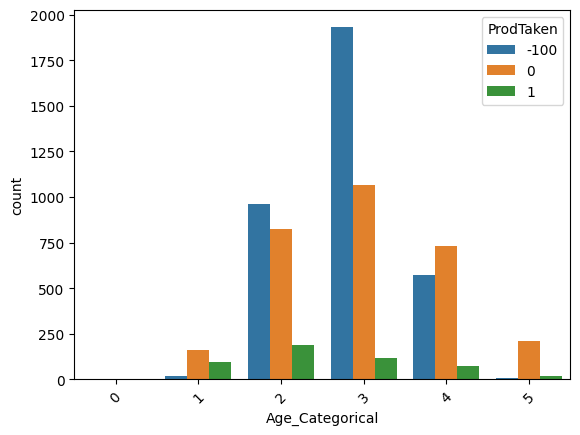

array([4, 5, 3, 1, 2, 0])

In [23]:
#ÁâπÈï∑Èáè„ÅÆ„Ç´„ÉÜ„Ç¥„É™„Ç´„É´Â§âÊï∞„Çí‰ΩúÊàê„Åô„Çã
# Age„Çí18Ê≠≥Êú™Ê∫Ä„ÄÅ18-24Ê≠≥„ÄÅ25-34Ê≠≥„ÄÅ35-44Ê≠≥„ÄÅ45-54Ê≠≥„ÄÅ55-64Ê≠≥„ÄÅ65-74Ê≠≥„ÄÅ75Ê≠≥‰ª•‰∏ä„Å´ÂàÜ„ÅëÊ≠≥‰ª£„Çí‰ΩúÊàê„Åô„Çã„ÄÇ
df["Age_Categorical"] = pd.cut(df["Age"], bins=[0, 18, 25, 35, 45, 55, 65, 75, 100], right=False)
# Âπ¥‰ª£„Åî„Å®„ÅÆÊàêÁ¥ÑÊàêÂäü„Åã„Å©„ÅÜ„Åã„ÇíÂèØË¶ñÂåñ„Åô„Çã
df["Age_Categorical"] = LabelEncoder().fit_transform(df["Age_Categorical"])
sns.countplot(x="Age_Categorical", hue="ProdTaken", data=df)
plt.xticks(rotation=45)
plt.show()
df["Age_Categorical"].unique()

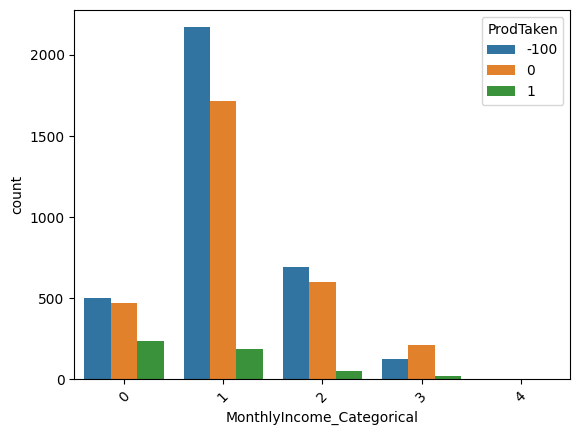

In [24]:
#ÁâπÈï∑Èáè„ÅÆ„Ç´„ÉÜ„Ç¥„É™„Ç´„É´Â§âÊï∞„Çí‰ΩúÊàê„Åô„Çã
# MonthlyIncome„Çí0-10‰∏áÂÜÜ„ÄÅ10-20‰∏áÂÜÜ„ÄÅ20-30‰∏áÂÜÜ„ÄÅ30-40‰∏áÂÜÜ„ÄÅ40-50‰∏áÂÜÜ„ÄÅ50-60‰∏áÂÜÜ„ÄÅ60-70‰∏áÂÜÜ„ÄÅ70-80‰∏áÂÜÜ„ÄÅ80-90‰∏áÂÜÜ„ÄÅ90-100‰∏áÂÜÜ„ÄÅ100‰∏áÂÜÜ‰ª•‰∏ä„Å´ÂàÜ„ÅëÊúàÂèé„Çí‰ΩúÊàê„Åô„Çã„ÄÇ
df["MonthlyIncome_Categorical"] = pd.cut(df["MonthlyIncome"], bins=[0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 100000000], right=False)
# ÊúàÂèé„Åî„Å®„ÅÆÊàêÁ¥ÑÊàêÂäü„Åã„Å©„ÅÜ„Åã„ÇíÂèØË¶ñÂåñ„Åô„Çã
df["MonthlyIncome_Categorical"] = LabelEncoder().fit_transform(df["MonthlyIncome_Categorical"])
sns.countplot(x="MonthlyIncome_Categorical", hue="ProdTaken", data=df)
plt.xticks(rotation=45)
plt.show()



In [25]:
#ÁâπÈï∑Èáè„ÅÆ„Ç´„ÉÜ„Ç¥„É™„Ç´„É´Â§âÊï∞„Çí‰ΩúÊàê„Åô„Çã
# DurationOfPitch„Çí0-100Áßí„ÄÅ100-200Áßí„ÄÅ200-300Áßí„ÄÅ300-400Áßí„ÄÅ400-500Áßí„ÄÅ500-600Áßí„ÄÅ600-700Áßí„ÄÅ700-800Áßí„ÄÅ800-900Áßí„ÄÅ900-1000Áßí„ÄÅ1000Áßí‰ª•‰∏ä„Å´ÂàÜ„Åë„Éó„É¨„Çº„É≥„ÉÜ„Éº„Ç∑„Éß„É≥ÊôÇÈñì„Çí‰ΩúÊàê„Åô„Çã„ÄÇ
df["DurationOfPitch_Categorical"] = pd.cut(df["DurationOfPitch"], bins=[0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000,2200, 2400, 100000000], right=False)
# „Éó„É¨„Çº„É≥„ÉÜ„Éº„Ç∑„Éß„É≥ÊôÇÈñì„Åî„Å®„ÅÆÊàêÁ¥ÑÊàêÂäü„Åã„Å©„ÅÜ„Åã„ÇíÂèØË¶ñÂåñ„Åô„Çã
df["DurationOfPitch_Categorical"] = LabelEncoder().fit_transform(df["DurationOfPitch_Categorical"])
sns.countplot(x="DurationOfPitch_Categorical", hue="ProdTaken", data=df)
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


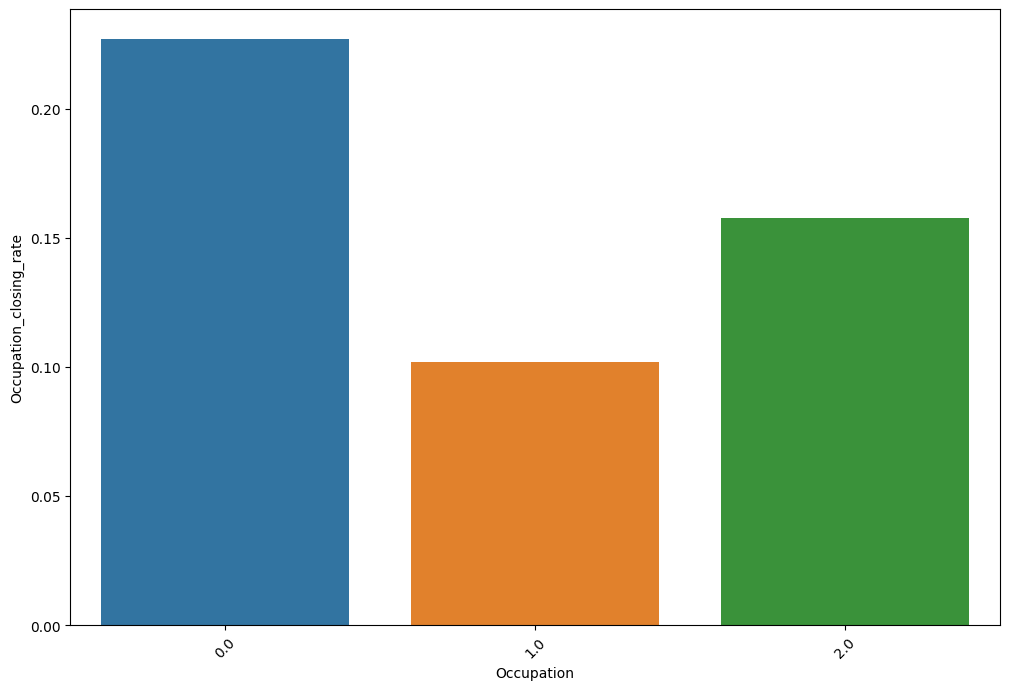

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


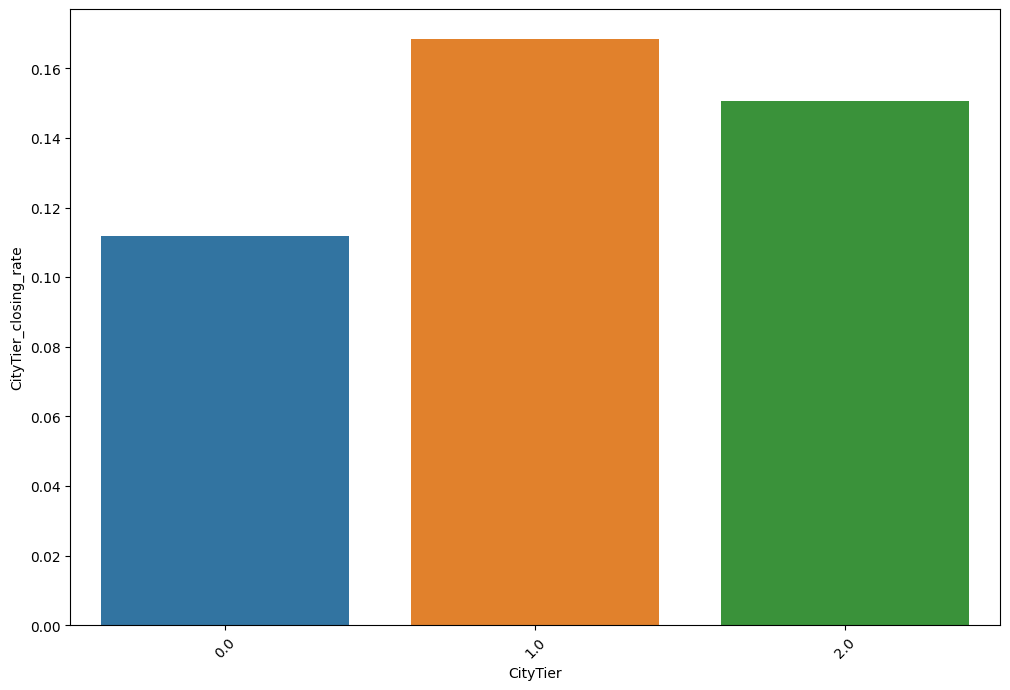

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


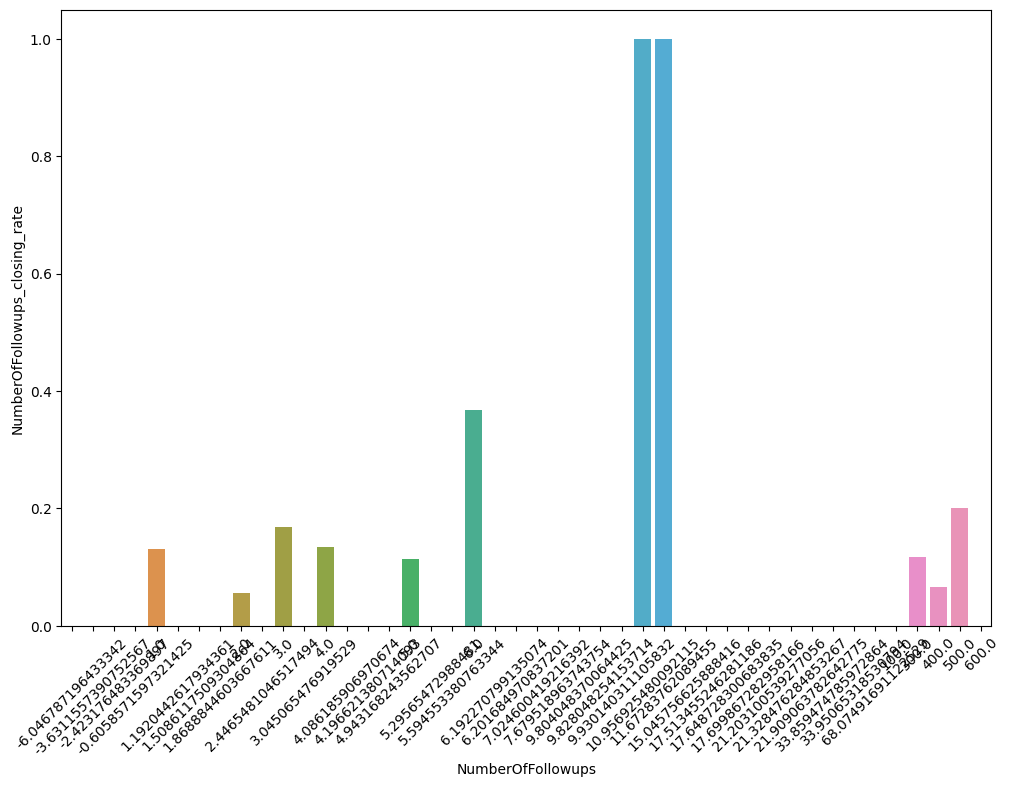

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


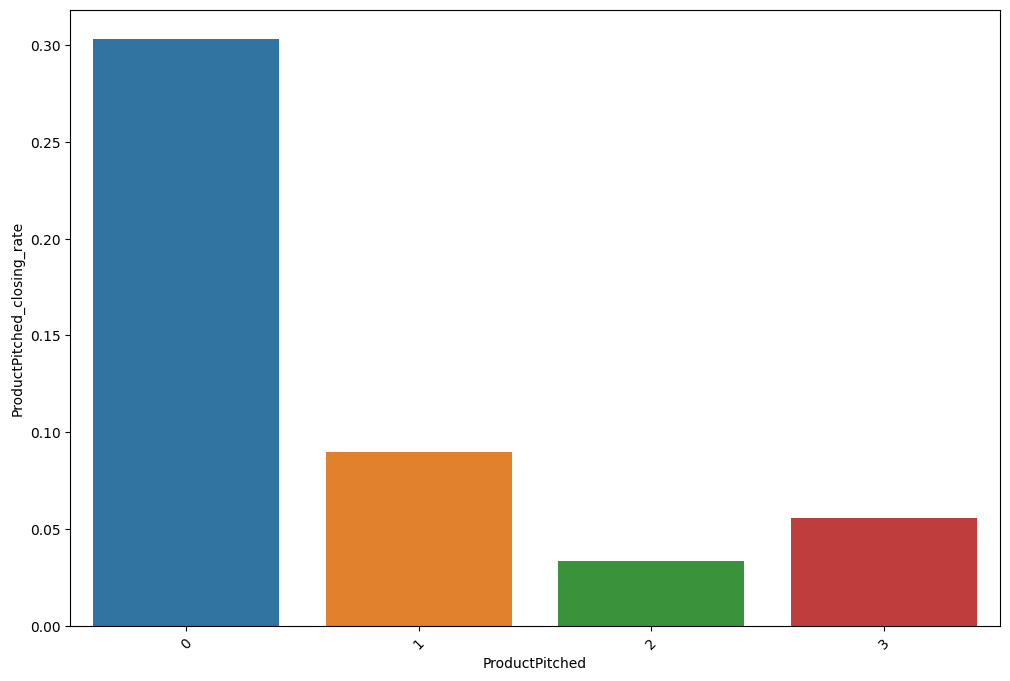

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


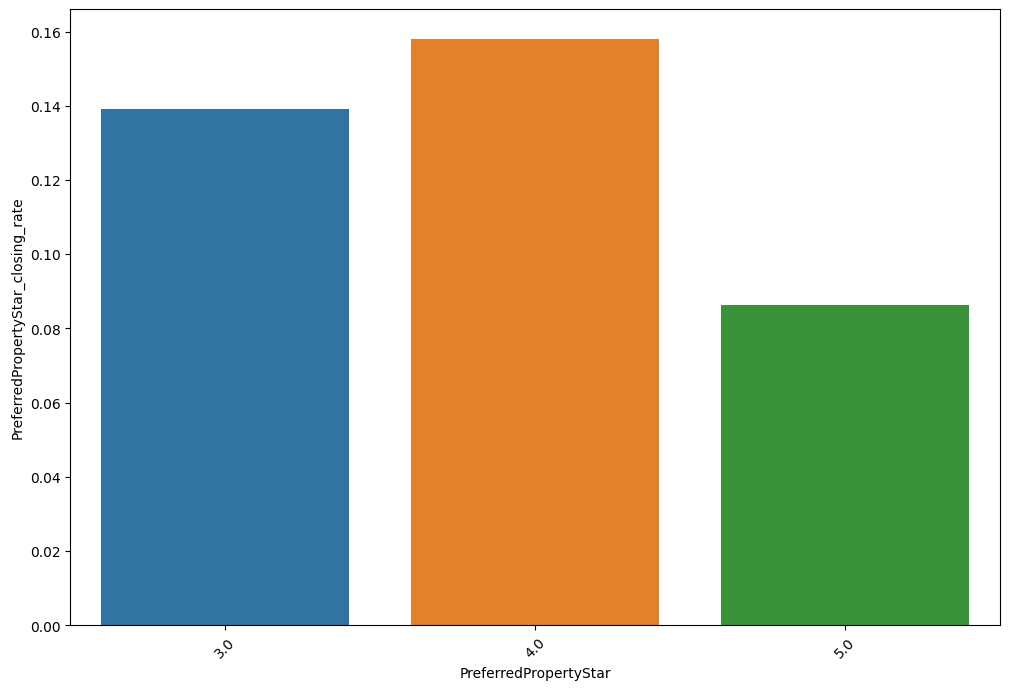

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


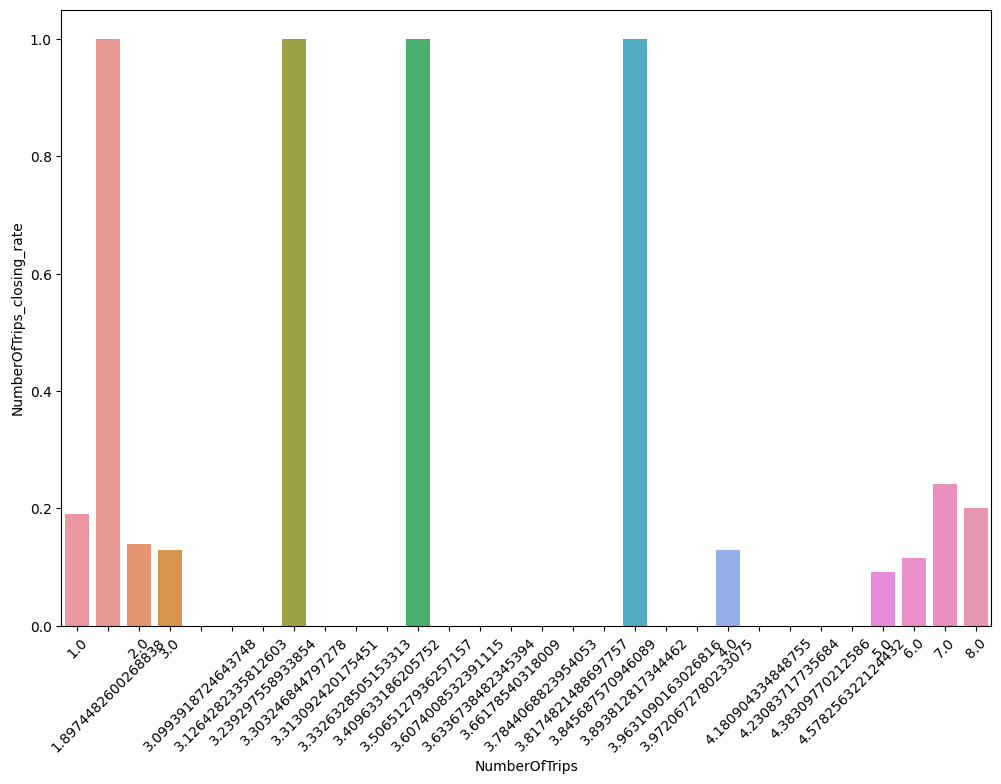

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


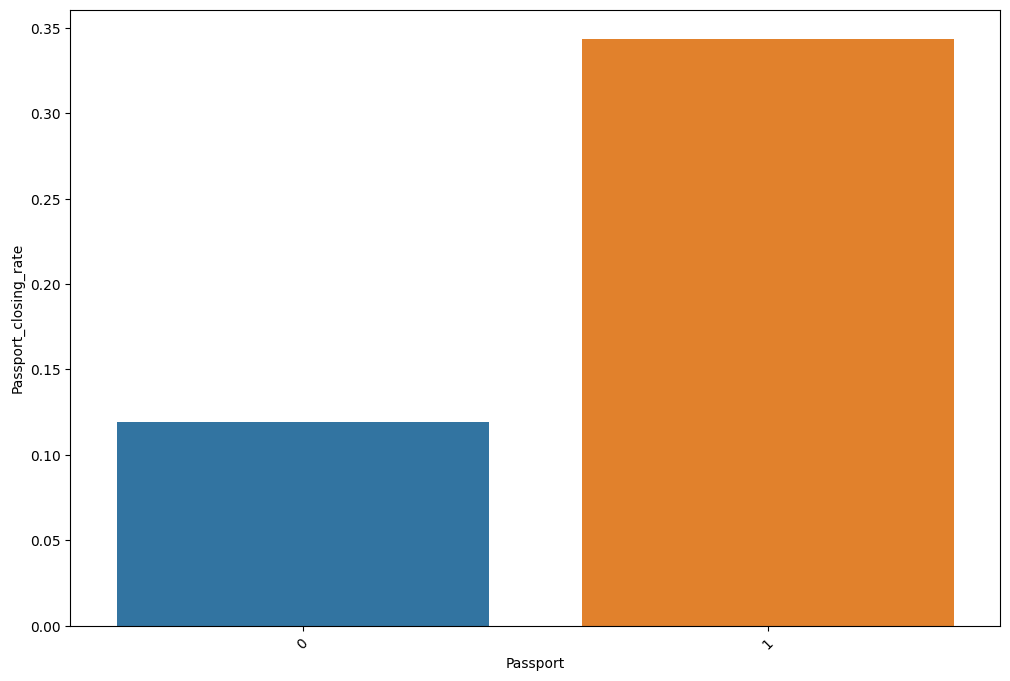

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


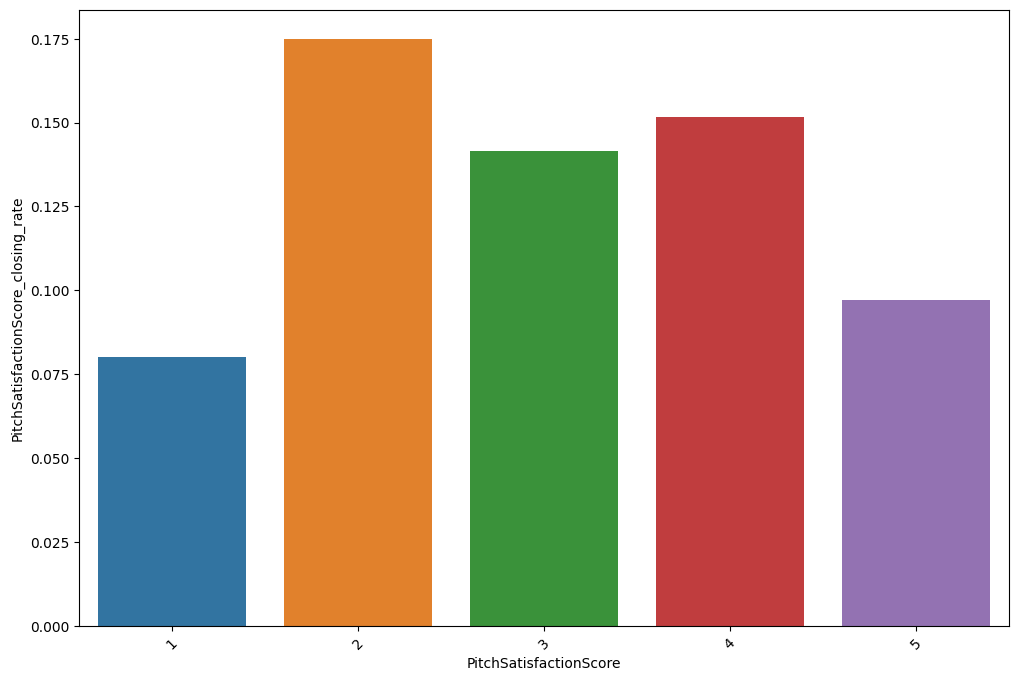

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


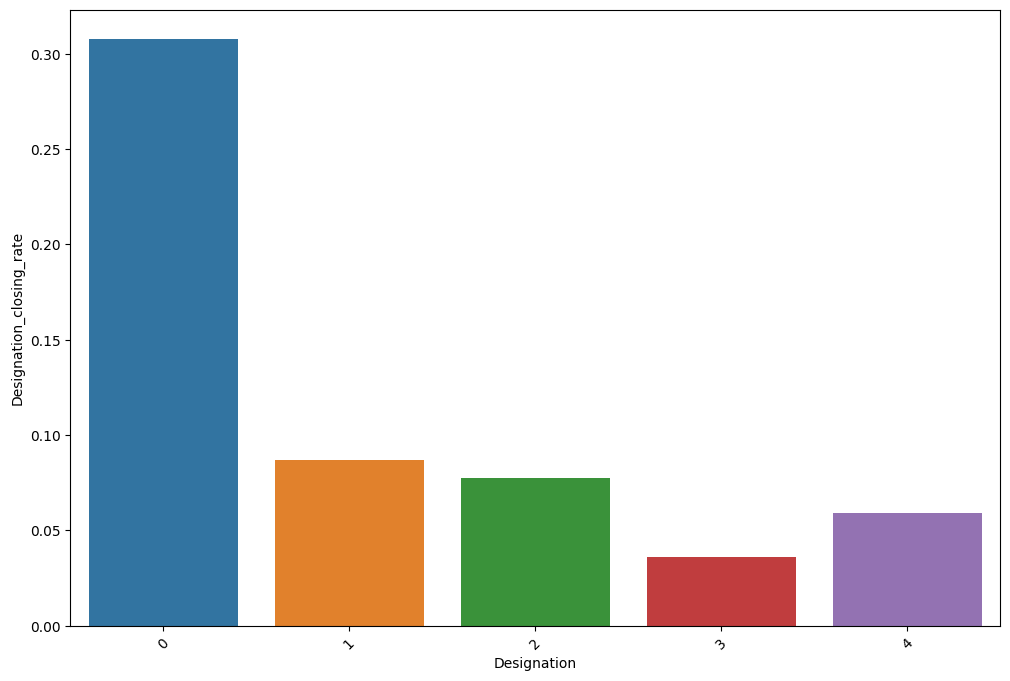

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


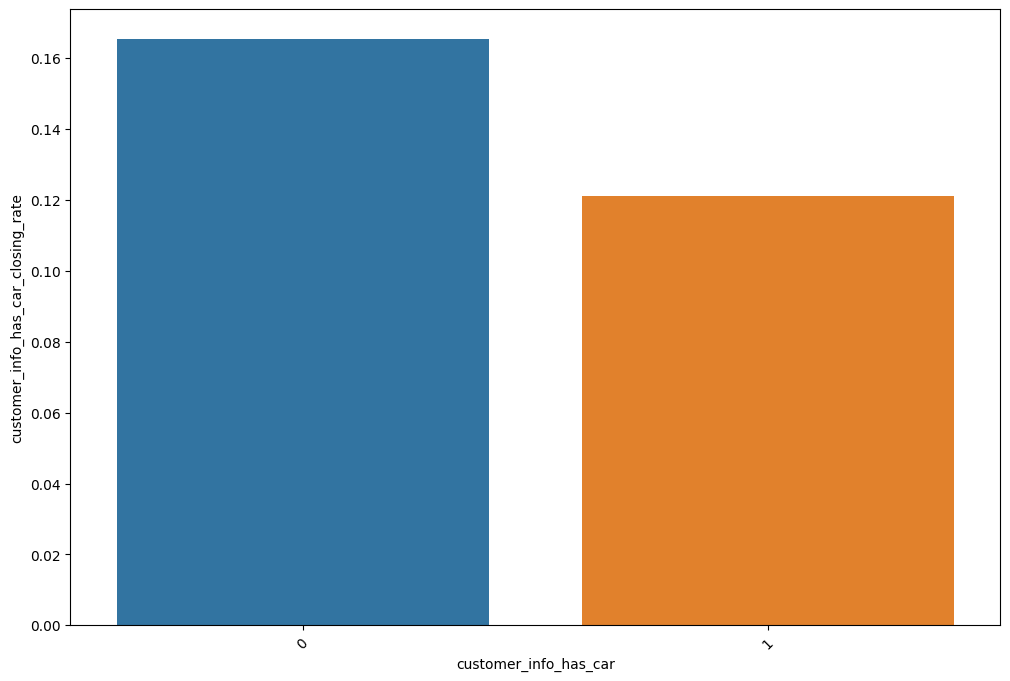

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


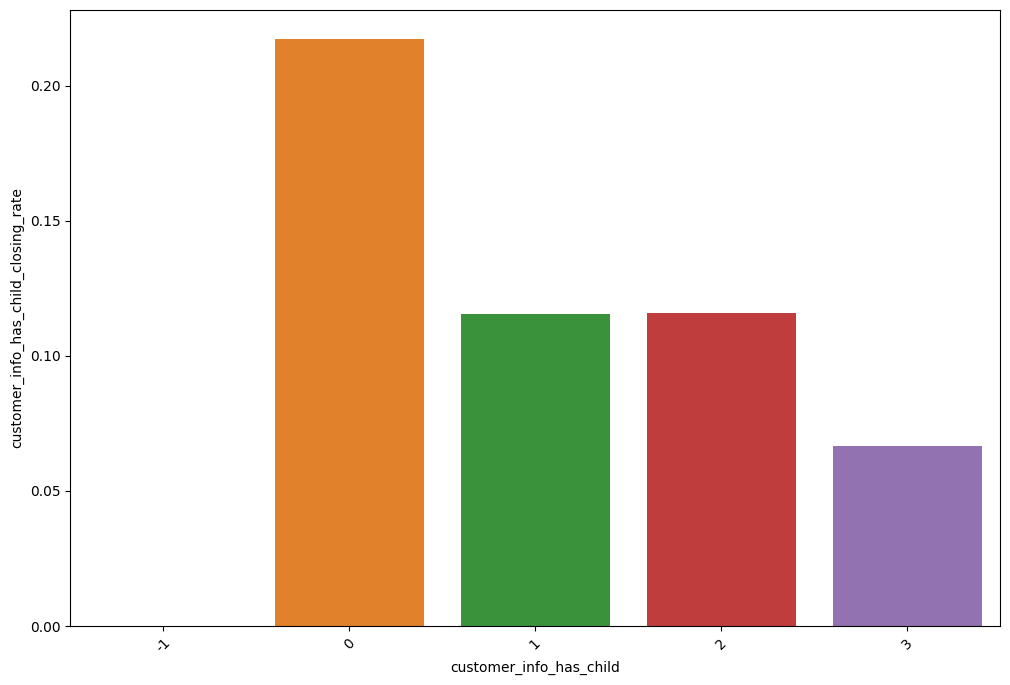

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


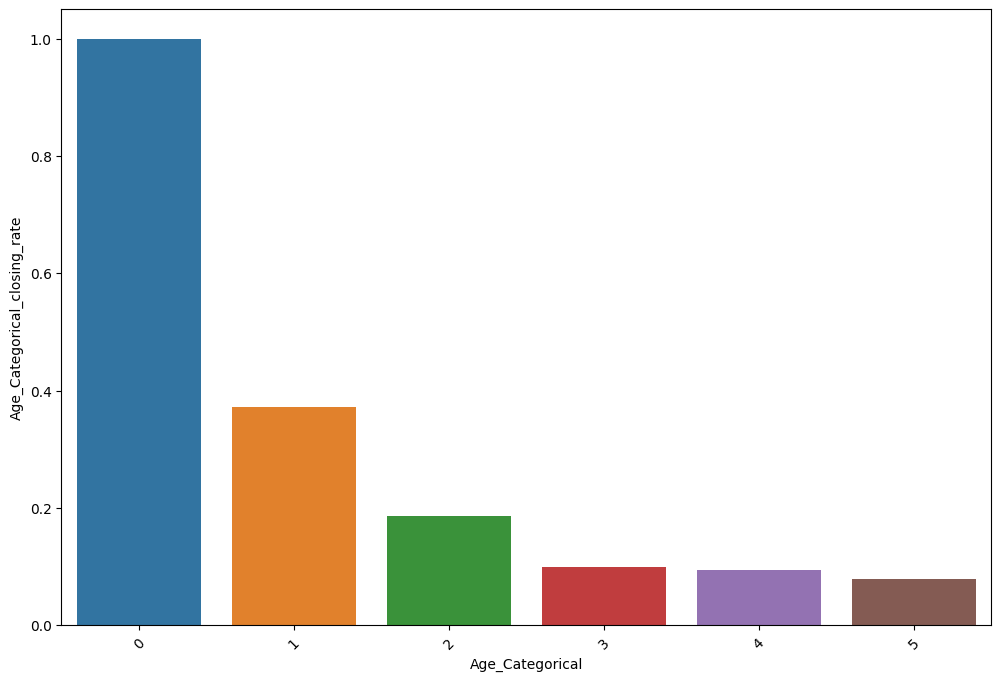

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


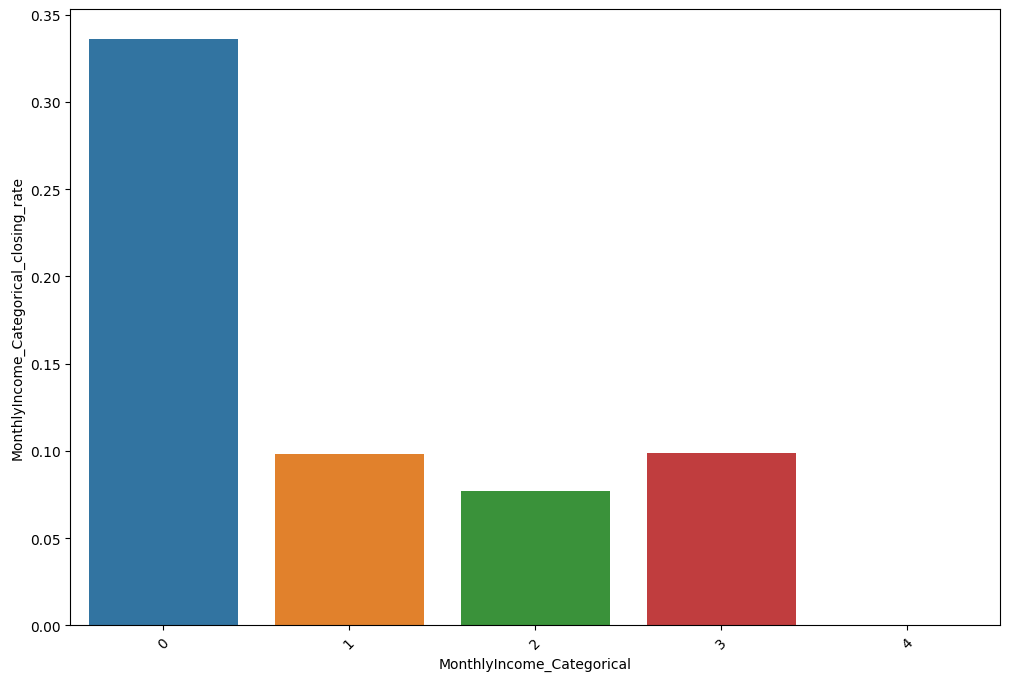

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


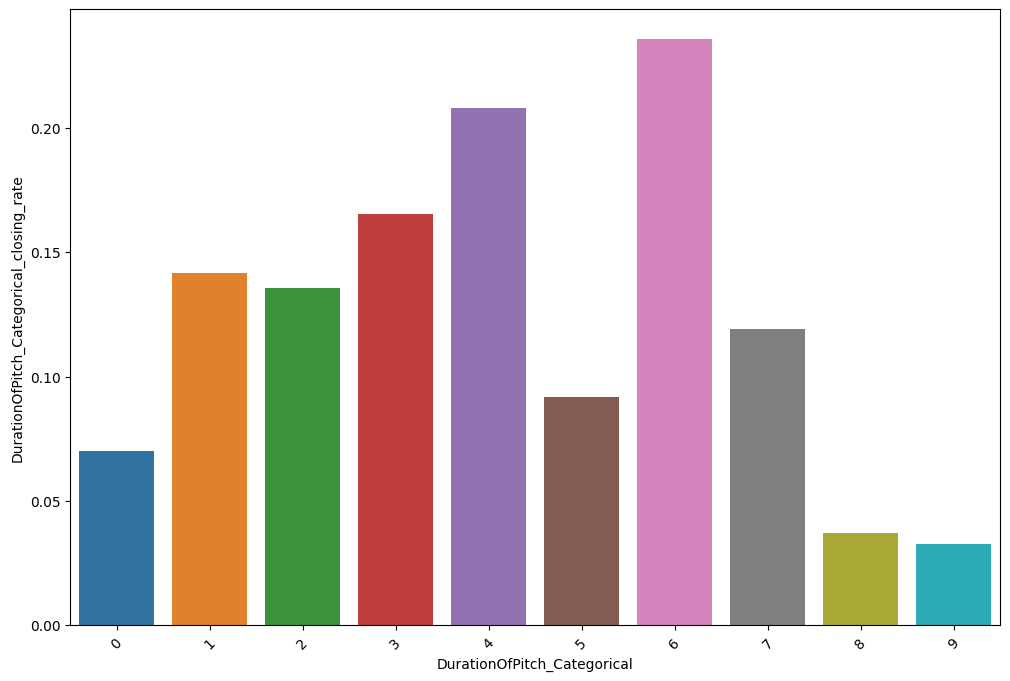

array([0., 1., 2., 3.])

In [26]:
# ÁâπÈï∑ÈáèÁîüÊàê„ÇíË°å„ÅÜ
# ÊàêÁ¥ÑÁéá„Çí‰ΩøÁî®„Åó„ÅüÁâπÈï∑ÁîüÊàê„ÇíË°å„Å£„Å¶„Åø„Çã
df_train_gen, df_test_gen = split_train_test(df)

def calculate_prodtaken_rate(df_train_gen,df_test_gen,columns):
    # Êñ∞„Åü„Å´‰ΩúÊàê„Åó„ÅüÁâπÈï∑ÈáèÂêç„ÇíÊ†ºÁ¥ç„Åô„Çã„É™„Çπ„Éà
    new_columns = []
    for col in columns:
        # „Ç®„É©„Éº„ÅåËµ∑„Åç„Å™„ÅÑ„Çà„ÅÜpivot_table„ÇíÂàùÊúüÂåñ„Åô„Çã
        pivot_table = pd.DataFrame()
        pivot_table = df_train_gen.pivot_table(values="ProdTaken", index=col, aggfunc="mean")
        pivot_table_fraud =pivot_table.reset_index()
        # ProdTaken_rate_colÂêç„ÅßÊñ∞„Åó„ÅÑÂàó„Çí‰ΩúÊàê„Åô„Çã
        pivot_table2 = pd.merge(df_train_gen, pivot_table_fraud, how='left',left_on=col, right_on=col,suffixes=('_total','_rate'))
        df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
        pivot_table3 = pd.merge(df_test_gen, pivot_table_fraud, how='left',left_on=col, right_on=col,suffixes=('_total','_rate'))
        df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]
        plt.figure(figsize=(12, 8))
        sns.barplot(x=col, y=col + "_closing_rate", data=df_train_gen)
        plt.xticks(rotation=45)
        plt.show()
        df_test_gen.head()
        new_columns.append(col + "_closing_rate")
    return df_train_gen,df_test_gen,new_columns 

columns = ["Occupation","TypeofContact","CityTier","Gender","NumberOfPersonVisiting",
           "NumberOfFollowups","ProductPitched","PreferredPropertyStar","NumberOfTrips","Passport",
              "PitchSatisfactionScore","Designation","customer_info_marry","customer_info_has_car",
                "customer_info_has_child",
           "Age_Categorical","MonthlyIncome_Categorical","DurationOfPitch_Categorical"
           ]
df_train_gen,df_test_gen, new_columns = calculate_prodtaken_rate(df_train_gen,df_test_gen,columns)

# ÂàÜÈõ¢„Åó„Åü„Éá„Éº„Çø„ÇíÁµêÂêà„Åô„Çã
df = merge_train_test(df_train_gen, df_test_gen)
df["NumberOfPersonVisiting"].unique()


In [27]:
new_columns

['Occupation_closing_rate',
 'TypeofContact_closing_rate',
 'CityTier_closing_rate',
 'Gender_closing_rate',
 'NumberOfPersonVisiting_closing_rate',
 'NumberOfFollowups_closing_rate',
 'ProductPitched_closing_rate',
 'PreferredPropertyStar_closing_rate',
 'NumberOfTrips_closing_rate',
 'Passport_closing_rate',
 'PitchSatisfactionScore_closing_rate',
 'Designation_closing_rate',
 'customer_info_marry_closing_rate',
 'customer_info_has_car_closing_rate',
 'customer_info_has_child_closing_rate',
 'Age_Categorical_closing_rate',
 'MonthlyIncome_Categorical_closing_rate',
 'DurationOfPitch_Categorical_closing_rate']

In [28]:
# ÊàêÁ¥ÑÁéá‰ª•Â§ñ„Çí‰ΩøÁî®„Åó„Å¶ÁâπÈï∑Èáè„ÇíÁîüÊàê„Åô„Çã
# „Ç´„ÉÜ„Ç¥„É™„Ç´„É´Â§âÊï∞„ÅÆÁµÑ„ÅøÂêà„Çè„Åõ„ÅßÊñ∞„Åü„Å™ÁâπÈï∑Èáè„ÇíÁîüÊàê„Åô„Çã

def create_categorical_combination(df):
    # Êñ∞„Åü„Å´‰ΩúÊàê„Åó„ÅüÁâπÈï∑ÈáèÂêç„ÇíÊ†ºÁ¥ç„Åô„Çã„É™„Çπ„Éà
    new_columns = []
    generate_columns =["Age_Categorical","MonthlyIncome_Categorical","DurationOfPitch_Categorical",
                       "Occupation","CityTier","TypeofContact","NumberOfPersonVisiting",
                       "NumberOfFollowups","ProductPitched","PreferredPropertyStar","Designation","customer_info_marry",
                       "customer_info_has_car","customer_info_has_child","Gender","NumberOfTrips","Passport","PitchSatisfactionScore"]
    for col1 in generate_columns:
        for col2 in generate_columns:
            # col1„Å®col2„ÅåÂêå‰∏Ä„Å†„Å£„ÅüÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó„Åô„Çã
            if col1 == col2:
                continue
            # col1„Å®col2„ÅåÈÄÜÈ†Ü„ÅßÊó¢„Å´‰ΩúÊàêÊ∏à„Åø„ÅÆÁâπÈï∑Èáè„Åå„ÅÇ„ÇãÂ†¥Âêà„ÅØ„Çπ„Ç≠„ÉÉ„Éó„Åô„Çã
            if col2 + "_" + col1 in new_columns:
                continue
            df[col1 + "_" + col2] = df[col1].astype(str) + "_" + df[col2].astype(str)
            df[col1 + "_" + col2] = LabelEncoder().fit_transform(df[col1 + "_" + col2])
            # sns.countplot(x=col1 + "_" + col2, hue="ProdTaken", data=df)
            # plt.xticks(rotation=45)
            # plt.show()
            new_columns.append(col1 + "_" + col2)
    return df, new_columns

df, new_columns_categorical_colob = create_categorical_combination(df)


/tmp/ipykernel_17180/1508795753.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col1 + "_" + col2] = df[col1].astype(str) + "_" + df[col2].astype(str)
/tmp/ipykernel_17180/1508795753.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col1 + "_" + col2] = df[col1].astype(str) + "_" + df[col2].astype(str)
/tmp/ipykernel_17180/1508795753.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns a

In [29]:
print(len(new_columns_categorical_colob))
new_columns_categorical_colob


153


['Age_Categorical_MonthlyIncome_Categorical',
 'Age_Categorical_DurationOfPitch_Categorical',
 'Age_Categorical_Occupation',
 'Age_Categorical_CityTier',
 'Age_Categorical_TypeofContact',
 'Age_Categorical_NumberOfPersonVisiting',
 'Age_Categorical_NumberOfFollowups',
 'Age_Categorical_ProductPitched',
 'Age_Categorical_PreferredPropertyStar',
 'Age_Categorical_Designation',
 'Age_Categorical_customer_info_marry',
 'Age_Categorical_customer_info_has_car',
 'Age_Categorical_customer_info_has_child',
 'Age_Categorical_Gender',
 'Age_Categorical_NumberOfTrips',
 'Age_Categorical_Passport',
 'Age_Categorical_PitchSatisfactionScore',
 'MonthlyIncome_Categorical_DurationOfPitch_Categorical',
 'MonthlyIncome_Categorical_Occupation',
 'MonthlyIncome_Categorical_CityTier',
 'MonthlyIncome_Categorical_TypeofContact',
 'MonthlyIncome_Categorical_NumberOfPersonVisiting',
 'MonthlyIncome_Categorical_NumberOfFollowups',
 'MonthlyIncome_Categorical_ProductPitched',
 'MonthlyIncome_Categorical_Preferr

ProdTaken
1    0.142448
Name: count, dtype: float64


Text(-0.5, 10, 'contract rate  = 0.14244769274863858')

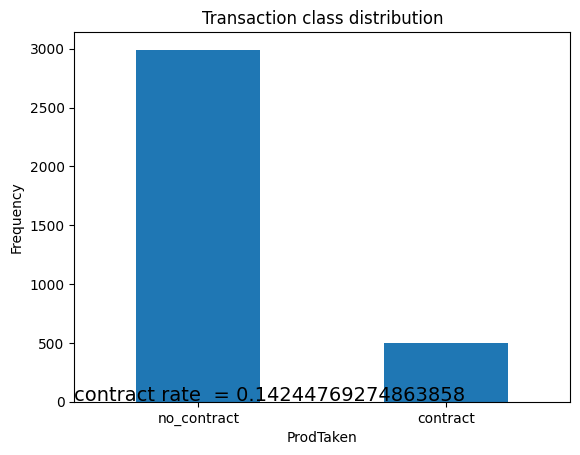

In [30]:
# Ê≠£Â∏∏„Éá„Éº„Çø„Å®Áï∞Â∏∏„Éá„Éº„Çø„ÅÆÈ†ªÂ∫¶„ÇíÁ¢∫Ë™ç
import matplotlib.pyplot as plt
LABELS = ["no_contract", "contract"]

no_contract = train[train.ProdTaken == 0]
no_contract_num = no_contract['ProdTaken'].value_counts()
contract = train[train.ProdTaken == 1]
contract_num = contract['ProdTaken'].value_counts()
# ÊàêÁ¥ÑÁéá„ÇíÁÆóÂá∫
rate = contract_num / (no_contract_num[0] + contract_num[1])
print(rate)
count_classes = pd.value_counts(train['ProdTaken'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("ProdTaken")
plt.ylabel("Frequency")
plt.text(-0.5, 10, 'contract rate  = {}'.format(rate[1]), fontsize = 14)

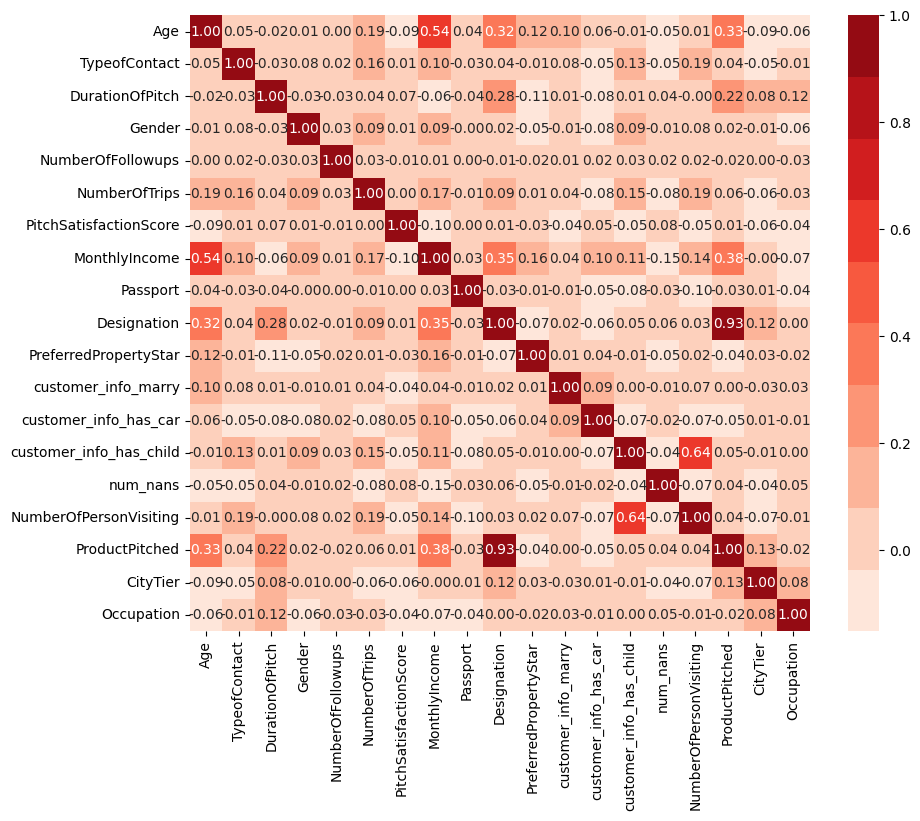

In [31]:
# ÊÉÖÂ†±Èáè„ÅåÂ§ö„ÅèÂá¶ÁêÜ„ÅåÂÆå‰∫Ü„Åó„Å™„ÅÑ„ÅÆ„Åß8Êúà„Åæ„Åß„ÅÆ„Éá„Éº„Çø„Åß„Éí„Éº„Éà„Éû„ÉÉ„ÉóÁÆóÂá∫„Åô„Çã
import seaborn as sns
%matplotlib inline
corrs = np.corrcoef(df[features], rowvar=False)
fig,ax = plt.subplots(figsize=(10,8))

sns.heatmap(corrs, cmap=sns.color_palette('Reds', 10), annot=True,
            fmt='.2f', xticklabels=df[features].columns.tolist(), yticklabels=df[features].columns.tolist())
# input_features = ["x_customer_id","y_customer_id","x_terminal_id","y_terminal_id","distance",'TX_AMOUNT',"TX_AMOUNT-mean","mean_amount","std_amount","mean_nb_tx_per_day"]
# sns.heatmap(train_total[input_features],vmax=1, vmin=-1, center=0)
plt.savefig("heatmap.png")

In [32]:
##ÁâπÂæ¥ÈÅ∏Êäû

In [33]:
##ÁâπÂæ¥ÈÅ∏Êäû
!pip install imblearn

In [34]:

# #kËøëÂÇçÊ≥ï„ÅÆ„Ç∞„É´„Éº„ÉóÊï∞?
# knn_n_neighbors = 6


# # parameters - knn feature weights
# # ‰ª•‰∏ã„ÄÅkNN„ÅÆÂ≠¶ÁøíÊôÇ„ÅÆ„Éë„É©„É°„Éº„ÇøÂÆöÁæ©„ÄÇregion„ÅØ„É©„Éô„É´„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„ÄÅ„Åù„ÅÆ‰ªñ„ÅÆÈáèÁöÑÂ§âÊï∞„ÅØÊ®ôÊ∫ñÂåñ„ÄÅ„Åù„Çå‰ª•Â§ñ„Å´nan„ÅÆÊï∞„ÇÇÁâπÂæ¥Èáè„Å®„Åó„Å¶‰Ωø„Å£„Å¶„ÅÑ„Çã„ÄÇ
# knn_features = [
#    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
#    'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
#    'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
#    'region_S', 'region_T', 'region_unknown',
#    'standardscaled_popularity', 'standardscaled_duration_ms',
#    'standardscaled_acousticness', 'standardscaled_positiveness',
#    'standardscaled_danceability', 'standardscaled_loudness',
#    'standardscaled_energy', 'standardscaled_liveness',
#    'standardscaled_speechiness', 'standardscaled_instrumentalness',
#    'standardscaled_log_tempo', 'standardscaled_num_nans'
# ]

# dict_feature_weights = {}

# # region„ÅÆÁâπÈï∑ÈáèÈáç„Åø„ÇíË®≠ÂÆö„ÄÇ
# # ‰ª•‰∏ã„ÅÆ„Çà„ÅÜ„Å´Èáç„Åø„ÇíÊ±∫„ÇÅ„Å¶„ÅÑ„Åè„Åì„Å®„Åå„Åß„Åç„Çã„Çâ„Åó„ÅÑ„ÄÇ
# # Èáç„Åø„Åß„Åô„Åå„ÄÅÊúÄÂàù„Å´Â§ß„Åæ„Åã„Å´ÂΩì„Åü„Çä„Çí„Å§„Åë(region„ÅØÈÅï„ÅÜ„ÇÇ„ÅÆ„ÅåËøëÂÇç„Éá„Éº„Çø„Å®„Åó„Å¶ÈÅ∏„Å∞„Çå„Å™„ÅÑ„Åè„Çâ„ÅÑÂ§ß„Åç„ÇÅ„ÄÅpopularity„ÇÇ‰ªñ„ÅÆÁâπÂæ¥„Çà„ÇäÂ§ß„Åç„ÇÅ„Å™„Å©)„ÄÅ
# # ‰∫§Â∑ÆÊ§úË®º„Åß„ÅÆÁ≤æÂ∫¶„ÇíË¶ã„Å™„Åå„ÇâÁ¥∞„Åã„ÅÑË™øÊï¥„Çí„Åó„Å¶„ÅÑ„Åæ„Åô„ÄÇ
# for col in [
#     'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
#     'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
#     'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
#     'region_S', 'region_T', 'region_unknown'
# ]:
#     dict_feature_weights[col] = 100.0

# for col in [
#     'standardscaled_duration_ms',
#     'standardscaled_acousticness', 'standardscaled_positiveness',
#     'standardscaled_danceability', 'standardscaled_loudness',
#     'standardscaled_energy', 'standardscaled_liveness',
#     'standardscaled_speechiness', 'standardscaled_instrumentalness'
# ]:
#     dict_feature_weights[col] = 1.0

# # popularity„ÅØ‰ªñ„ÅÆÁâπÂæ¥„Çà„Çä„ÇÇÂ§ß„Åç„ÇÅ„Å´Ë®≠ÂÆö„ÄÇ
# dict_feature_weights["standardscaled_popularity"] = 9.0
# dict_feature_weights["standardscaled_log_tempo"] = 0.001
# dict_feature_weights["standardscaled_num_nans"] = 100.0

# # acousticness„ÅØlightgbm„ÅßÈáçË¶Å„Å†„Å£„Åü„ÅÆ„Åß„ÄÅÂ§ß„Åç„ÇÅ„Å´Ë®≠ÂÆö„ÄÇ
# dict_feature_weights["standardscaled_acousticness"] =3.0

# # kËøëÂÇçÊ≥ï„ÅÆÁâπÂæ¥ÈáèÈáç„Åø„ÇínumpyÈÖçÂàó„Å´Â§âÊèõ„ÄÇ
# knn_feature_weights = np.array([dict_feature_weights[col] for col in knn_features])
# print(knn_feature_weights)

# # train,test„Éá„Éº„Çø„Å´ÂØæ„Åó„Å¶ÁâπÈï∑Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞„ÇíË°å„ÅÜ„Åü„ÇÅ„ÄÅÂêà‰Ωì„Åï„Åõ„Çã„ÄÇ
# df_main = merge_train_test(df_train, df_test)

In [35]:
target = "ProdTaken"
df_train, df_test = split_train_test(df)
target = df_train[target]


# Â≠¶ÁøíÂâç„Å´df_train„ÅÆÁâπÂæ¥Èáè„ÇíÁ¢∫Ë™ç
# print(df_train.columns)
# train
# N_SPLITS„ÅØ‰∫§Â∑ÆÊ§úË®º„ÅÆÂàÜÂâ≤Êï∞„ÄÅSEED_SKF„ÅØ‰π±Êï∞„ÅÆ„Ç∑„Éº„ÉâÂÄ§„ÄÇ
N_SPLITS = 5
SEED_SKF = 42
N_CLASSES = 2
np.random.seed(42)

# StratifiedKFold„Åß„Éá„Éº„Çø„ÇíÂàÜÂâ≤„Åô„Çã„ÄÇ
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
# oof„ÅØout of fold„ÅÆÁï•„ÄÇ‰∫§Â∑ÆÊ§úË®º„ÅÆÁµêÊûú„ÇíÊ†ºÁ¥ç„Åô„Çã„Åü„ÇÅ„ÅÆÂ§âÊï∞„ÄÇ
oof = np.zeros((len(df_train), N_CLASSES))
oof_svc = np.zeros((len(df_train), N_CLASSES))
oof_mlp = np.zeros((len(df_train), N_CLASSES))
# ‰∫àÊ∏¨ÁµêÊûú„ÇíÊ†ºÁ¥ç„Åô„Çã„Åü„ÇÅ„ÅÆÂ§âÊï∞„ÄÇ
predictions = np.zeros((len(df_test), N_CLASSES))
predictions_svc = np.zeros((len(df_test), N_CLASSES))
predictions_mlp = np.zeros((len(df_test), N_CLASSES))

# ÁâπÂæ¥Èáè„ÅÆÈáçË¶ÅÂ∫¶„ÇíÊ†ºÁ¥ç„Åô„Çã„Åü„ÇÅ„ÅÆÂ§âÊï∞„ÄÇ
df_feature_importance = pd.DataFrame()


features_mlp = ["Age","TypeofContact","DurationOfPitch","Gender","NumberOfFollowups","NumberOfTrips","PitchSatisfactionScore","MonthlyIncome","Passport",
            # „Åì„Çå„Çâ„ÅØ„ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„Åó„Å¶„ÅÑ„Çã„ÅÆ„Åß‰ΩøÁî®„Åó„Å™„ÅÑ
            # "ProductPitched","PreferredPropertyStar","Designation",
            # "customer_info_marry","customer_info_has_car","customer_info_has_child",
            # „ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞
            "CityTier_1","CityTier_2","CityTier_3",
            "NumberOfPersonVisiting_1","NumberOfPersonVisiting_2","NumberOfPersonVisiting_3","NumberOfPersonVisiting_4",
            "ProductPitched_0","ProductPitched_1","ProductPitched_2","ProductPitched_3",
            "PreferredPropertyStar_3","PreferredPropertyStar_4","PreferredPropertyStar_5",
            "Designation_0","Designation_1","Designation_2","Designation_3","Designation_4",
            "customer_info_marry_0","customer_info_marry_1","customer_info_marry_2",
            "customer_info_has_car_0","customer_info_has_car_1",
            "customer_info_has_child_0","customer_info_has_child_1","customer_info_has_child_2","customer_info_has_child_3","customer_info_has_child_-1",
            
            # Áô∫ÁîüÂõûÊï∞„Çí„Ç´„Ç¶„É≥„Éà„Åó„Å¶„ÅÑ„Çã„Ç´„Ç¶„É≥„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞
            "countenc_CityTier","countenc_NumberOfPersonVisiting","countenc_NumberOfFollowups","countenc_ProductPitched","countenc_NumberOfTrips","countenc_Passport","countenc_PitchSatisfactionScore","countenc_Designation","countenc_customer_info_marry","countenc_customer_info_has_car","countenc_customer_info_has_child",
            
            # „ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„Åó„Å¶„ÅÑ„Çã„ÅÆ„Åß„É©„Éô„É´„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„ÅØ„Å≤„Å®„Åæ„Åö‰ΩøÁî®„Åó„Å™„ÅÑ
            # "labelenc_TypeofContact","labelenc_Occupation","labelenc_CityTier","labelenc_NumberOfPersonVisiting"
            ]

features_svc = ["Age","TypeofContact","DurationOfPitch","Gender","NumberOfFollowups","NumberOfTrips","PitchSatisfactionScore","MonthlyIncome","Passport",
            # „Åì„Çå„Çâ„ÅØ„ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„Åó„Å¶„ÅÑ„Çã„ÅÆ„Åß‰ΩøÁî®„Åó„Å™„ÅÑ
            # "ProductPitched","PreferredPropertyStar","Designation",
            # "customer_info_marry","customer_info_has_car","customer_info_has_child",
            # „ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞
            "CityTier_1","CityTier_2","CityTier_3",
            "NumberOfPersonVisiting_1","NumberOfPersonVisiting_2","NumberOfPersonVisiting_3","NumberOfPersonVisiting_4",
            "ProductPitched_0","ProductPitched_1","ProductPitched_2","ProductPitched_3",
            "PreferredPropertyStar_3","PreferredPropertyStar_4","PreferredPropertyStar_5",
            "Designation_0","Designation_1","Designation_2","Designation_3","Designation_4",
            "customer_info_marry_0","customer_info_marry_1","customer_info_marry_2",
            "customer_info_has_car_0","customer_info_has_car_1",
            "customer_info_has_child_0","customer_info_has_child_1","customer_info_has_child_2","customer_info_has_child_3","customer_info_has_child_-1",
            
            # Áô∫ÁîüÂõûÊï∞„Çí„Ç´„Ç¶„É≥„Éà„Åó„Å¶„ÅÑ„Çã„Ç´„Ç¶„É≥„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞
            "countenc_CityTier","countenc_NumberOfPersonVisiting","countenc_NumberOfFollowups","countenc_ProductPitched","countenc_NumberOfTrips","countenc_Passport","countenc_PitchSatisfactionScore","countenc_Designation","countenc_customer_info_marry","countenc_customer_info_has_car","countenc_customer_info_has_child",
            
            # „ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„Åó„Å¶„ÅÑ„Çã„ÅÆ„Åß„É©„Éô„É´„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„ÅØ„Å≤„Å®„Åæ„Åö‰ΩøÁî®„Åó„Å™„ÅÑ
            # "labelenc_TypeofContact","labelenc_Occupation","labelenc_CityTier","labelenc_NumberOfPersonVisiting"
            ]

# ÁâπÈï∑Èáè„Å´‰Ωø„Åà„Çã„ÇÇ„ÅÆ„ÇíÈÅ∏Êäû„Åô„Çã„ÄÇ
# „Åæ„Åö„ÅØ„É©„Éô„É´„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„ÅØÂü∫Êú¨‰ΩøÁî®„Åõ„Åö„ÄÅ„ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„Çí‰ΩøÁî®„Åô„Çã„ÄÇ
            # „Åì„Çå„Çâ„ÅØÂ§âÊèõÂØæÂøú„Åó„Å¶„Åù„ÅÆ„Åæ„Åæ‰ΩøÁî®„Åô„Çã
features = ["Age","TypeofContact","DurationOfPitch","Gender","NumberOfFollowups","NumberOfTrips","PitchSatisfactionScore","MonthlyIncome","Passport",
            # „Åì„Çå„Çâ„ÅØ„ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„Åó„Å¶„ÅÑ„Çã„ÅÆ„Åß‰ΩøÁî®„Åó„Å™„ÅÑ
            # "ProductPitched","PreferredPropertyStar","Designation",
            # "customer_info_marry","customer_info_has_car","customer_info_has_child",
            # „ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞
            "CityTier_1","CityTier_2","CityTier_3",
            "NumberOfPersonVisiting_1","NumberOfPersonVisiting_2","NumberOfPersonVisiting_3","NumberOfPersonVisiting_4",
            "ProductPitched_0","ProductPitched_1","ProductPitched_2","ProductPitched_3",
            "PreferredPropertyStar_3","PreferredPropertyStar_4","PreferredPropertyStar_5",
            "Designation_0","Designation_1","Designation_2","Designation_3","Designation_4",
            "customer_info_marry_0","customer_info_marry_1","customer_info_marry_2",
            "customer_info_has_car_0","customer_info_has_car_1",
            "customer_info_has_child_0","customer_info_has_child_1","customer_info_has_child_2","customer_info_has_child_3","customer_info_has_child_-1",
            
            # Áô∫ÁîüÂõûÊï∞„Çí„Ç´„Ç¶„É≥„Éà„Åó„Å¶„ÅÑ„Çã„Ç´„Ç¶„É≥„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞
            # lightGBM„ÅØ„ÅÇ„Çä„Å†„Å®score‰∏ã„Åå„Çã„ÅÆ„Åß„Ç≥„É°„É≥„Éà„Ç¢„Ç¶„Éà
            "countenc_CityTier","countenc_NumberOfPersonVisiting","countenc_NumberOfFollowups","countenc_ProductPitched","countenc_NumberOfTrips","countenc_Passport","countenc_PitchSatisfactionScore","countenc_Designation","countenc_customer_info_marry","countenc_customer_info_has_car","countenc_customer_info_has_child",
            
            # nan„ÅÆÊï∞
            "num_nans",

            # „ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„Åó„Å¶„ÅÑ„Çã„ÅÆ„Åß„É©„Éô„É´„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„ÅØ„Å≤„Å®„Åæ„Åö‰ΩøÁî®„Åó„Å™„ÅÑ
            # "labelenc_Occupation","labelenc_CityTier","labelenc_NumberOfPersonVisiting"
            
            # „Ç´„ÉÜ„Ç¥„É™„Ç´„É´Â§âÊï∞„ÅÆËøΩÂä†
            'Age_Categorical','MonthlyIncome_Categorical','DurationOfPitch_Categorical',

            # ÊàêÁ¥ÑÁéá„Çí‰ΩøÁî®„Åó„ÅüÁâπÈï∑ÈáèËøΩÂä†
            'Occupation_closing_rate',
            'TypeofContact_closing_rate',
            'CityTier_closing_rate',
            'Gender_closing_rate',
            'NumberOfPersonVisiting_closing_rate',
            'NumberOfFollowups_closing_rate',
            'ProductPitched_closing_rate',
            'PreferredPropertyStar_closing_rate',
            'NumberOfTrips_closing_rate',
            'Passport_closing_rate',
            'PitchSatisfactionScore_closing_rate',
            'Designation_closing_rate',
            'customer_info_marry_closing_rate',
            'customer_info_has_car_closing_rate',
            'customer_info_has_child_closing_rate',
            'Age_Categorical_closing_rate',
            'MonthlyIncome_Categorical_closing_rate',
            'DurationOfPitch_Categorical_closing_rate',

            # „Ç´„ÉÜ„Ç¥„É™„Ç´„É´Â§âÊï∞„ÅÆÁµÑ„ÅøÂêà„Çè„Åõ„ÄÇ01„ÅÆ„ÇÇ„ÅÆ„ÅØ„Å™„Åè„Å¶„ÇÇ„Çà„Åï„ÅíÔºü
            'Age_Categorical_MonthlyIncome_Categorical',
            'Age_Categorical_DurationOfPitch_Categorical',
            'Age_Categorical_Occupation',
            'Age_Categorical_CityTier',
            'Age_Categorical_TypeofContact',
            'Age_Categorical_NumberOfPersonVisiting',
            'Age_Categorical_NumberOfFollowups',
            'Age_Categorical_ProductPitched',
            'Age_Categorical_PreferredPropertyStar',
            'Age_Categorical_Designation',
            'Age_Categorical_customer_info_marry',
            'Age_Categorical_customer_info_has_car',
            'Age_Categorical_customer_info_has_child',
            'Age_Categorical_Gender',
            'Age_Categorical_NumberOfTrips',
            'Age_Categorical_Passport',
            'Age_Categorical_PitchSatisfactionScore',
            'MonthlyIncome_Categorical_DurationOfPitch_Categorical',
            'MonthlyIncome_Categorical_Occupation',
            'MonthlyIncome_Categorical_CityTier',
            'MonthlyIncome_Categorical_TypeofContact',
            'MonthlyIncome_Categorical_NumberOfPersonVisiting',
            'MonthlyIncome_Categorical_NumberOfFollowups',
            'MonthlyIncome_Categorical_ProductPitched',
            'MonthlyIncome_Categorical_PreferredPropertyStar',
            'MonthlyIncome_Categorical_Designation',
            'MonthlyIncome_Categorical_customer_info_marry',
            'MonthlyIncome_Categorical_customer_info_has_car',
            'MonthlyIncome_Categorical_customer_info_has_child',
            'MonthlyIncome_Categorical_Gender',
            'MonthlyIncome_Categorical_NumberOfTrips',
            'MonthlyIncome_Categorical_Passport',
            'MonthlyIncome_Categorical_PitchSatisfactionScore',
            'DurationOfPitch_Categorical_Occupation',
            'DurationOfPitch_Categorical_CityTier',
            'DurationOfPitch_Categorical_TypeofContact',
            'DurationOfPitch_Categorical_NumberOfPersonVisiting',
            'DurationOfPitch_Categorical_NumberOfFollowups',
            'DurationOfPitch_Categorical_ProductPitched',
            'DurationOfPitch_Categorical_PreferredPropertyStar',
            'DurationOfPitch_Categorical_Designation',
            'DurationOfPitch_Categorical_customer_info_marry',
            'DurationOfPitch_Categorical_customer_info_has_car',
            'DurationOfPitch_Categorical_customer_info_has_child',
            'DurationOfPitch_Categorical_Gender',
            'DurationOfPitch_Categorical_NumberOfTrips',
            'DurationOfPitch_Categorical_Passport',
            'DurationOfPitch_Categorical_PitchSatisfactionScore',
            'Occupation_CityTier',
            'Occupation_TypeofContact',
            'Occupation_NumberOfPersonVisiting',
            'Occupation_NumberOfFollowups',
            'Occupation_ProductPitched',
            'Occupation_PreferredPropertyStar',
            'Occupation_Designation',
            'Occupation_customer_info_marry',
            'Occupation_customer_info_has_car',
            'Occupation_customer_info_has_child',
            'Occupation_Gender',
            'Occupation_NumberOfTrips',
            'Occupation_Passport',
            'Occupation_PitchSatisfactionScore',
            'CityTier_TypeofContact',
            'CityTier_NumberOfPersonVisiting',
            'CityTier_NumberOfFollowups',
            'CityTier_ProductPitched',
            'CityTier_PreferredPropertyStar',
            'CityTier_Designation',
            'CityTier_customer_info_marry',
            'CityTier_customer_info_has_car',
            'CityTier_customer_info_has_child',
            'CityTier_Gender',
            'CityTier_NumberOfTrips',
            'CityTier_Passport',
            'CityTier_PitchSatisfactionScore',
            'TypeofContact_NumberOfPersonVisiting',
            'TypeofContact_NumberOfFollowups',
            'TypeofContact_ProductPitched',
            'TypeofContact_PreferredPropertyStar',
            'TypeofContact_Designation',
            'TypeofContact_customer_info_marry',
            'TypeofContact_customer_info_has_car',
            'TypeofContact_customer_info_has_child',
            'TypeofContact_Gender',
            'TypeofContact_NumberOfTrips',
            'TypeofContact_Passport',
            'TypeofContact_PitchSatisfactionScore',
            'NumberOfPersonVisiting_NumberOfFollowups',
            'NumberOfPersonVisiting_ProductPitched',
            'NumberOfPersonVisiting_PreferredPropertyStar',
            'NumberOfPersonVisiting_Designation',
            'NumberOfPersonVisiting_customer_info_marry',
            'NumberOfPersonVisiting_customer_info_has_car',
            'NumberOfPersonVisiting_customer_info_has_child',
            'NumberOfPersonVisiting_Gender',
            'NumberOfPersonVisiting_NumberOfTrips',
            'NumberOfPersonVisiting_Passport',
            'NumberOfPersonVisiting_PitchSatisfactionScore',
            'NumberOfFollowups_ProductPitched',
            'NumberOfFollowups_PreferredPropertyStar',
            'NumberOfFollowups_Designation',
            'NumberOfFollowups_customer_info_marry',
            'NumberOfFollowups_customer_info_has_car',
            'NumberOfFollowups_customer_info_has_child',
            'NumberOfFollowups_Gender',
            'NumberOfFollowups_NumberOfTrips',
            'NumberOfFollowups_Passport',
            'NumberOfFollowups_PitchSatisfactionScore',
            'ProductPitched_PreferredPropertyStar',
            'ProductPitched_Designation',
            'ProductPitched_customer_info_marry',
            'ProductPitched_customer_info_has_car',
            'ProductPitched_customer_info_has_child',
            'ProductPitched_Gender',
            'ProductPitched_NumberOfTrips',
            'ProductPitched_Passport',
            'ProductPitched_PitchSatisfactionScore',
            'PreferredPropertyStar_Designation',
            'PreferredPropertyStar_customer_info_marry',
            'PreferredPropertyStar_customer_info_has_car',
            'PreferredPropertyStar_customer_info_has_child',
            'PreferredPropertyStar_Gender',
            'PreferredPropertyStar_NumberOfTrips',
            'PreferredPropertyStar_Passport',
            'PreferredPropertyStar_PitchSatisfactionScore',
            'Designation_customer_info_marry',
            'Designation_customer_info_has_car',
            'Designation_customer_info_has_child',
            'Designation_Gender',
            'Designation_NumberOfTrips',
            'Designation_Passport',
            'Designation_PitchSatisfactionScore',
            'customer_info_marry_customer_info_has_car',
            'customer_info_marry_customer_info_has_child',
            'customer_info_marry_Gender',
            'customer_info_marry_NumberOfTrips',
            'customer_info_marry_Passport',
            'customer_info_marry_PitchSatisfactionScore',
            'customer_info_has_car_customer_info_has_child',
            'customer_info_has_car_Gender',
            'customer_info_has_car_NumberOfTrips',
            'customer_info_has_car_Passport',
            'customer_info_has_car_PitchSatisfactionScore',
            'customer_info_has_child_Gender',
            'customer_info_has_child_NumberOfTrips',
            'customer_info_has_child_Passport',
            'customer_info_has_child_PitchSatisfactionScore',
            'Gender_NumberOfTrips',
            'Gender_Passport',
            'Gender_PitchSatisfactionScore',
            'NumberOfTrips_Passport',
            'NumberOfTrips_PitchSatisfactionScore',
            'Passport_PitchSatisfactionScore']
features_svc = features
features_mlp = features


In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# ÁâπÂæ¥Èáè„ÇíÂà∂Èôê„Åô„Çã„Åã„Å©„ÅÜ„Åã„ÅÆ„Éï„É©„Ç∞
features_limit = True

is_do_mlp_and_svc = False

# train data„ÅÆindex„Å®validation data„ÅÆindex„ÇíÂèñÂæó„Åó„Å¶„ÄÅreset_index„Åßindex„ÇíÊåØ„ÇäÁõ¥„Åó„Å¶„ÅÑ„Çã„ÄÇdrop=true„ÅØÂÖÉ„ÅÆindex„ÇíÂâäÈô§„Åô„Çã„Åü„ÇÅ„ÄÇ
# df_train = df_train.reset_index(drop=True)
# target = target.reset_index(drop=True)
df_trn, df_val, target_trn, target_val = train_test_split(df_train, target, test_size=0.2, random_state=42)

# # make knn features
# X = df_trn[knn_features].fillna(0.0).values * knn_feature_weights
# knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(X, target_trn)
# df_trn = pd.concat([df_trn, knn_feature_extractor.transform(X, is_train_data=True)], axis=1)

# X = df_val[knn_features].fillna(0.0).values * knn_feature_weights
# df_val = pd.concat([df_val, knn_feature_extractor.transform(X, is_train_data=False)], axis=1)

# X = df_test[knn_features].fillna(0.0).values * knn_feature_weights
# df_test_knn_features = knn_feature_extractor.transform(X, is_train_data=False)

# #  kËøëÂÇçÊ≥ï„ÅÆÁâπÂæ¥Èáè„ÇíËøΩÂä†
# for col in df_test_knn_features.columns:
#     df_test[col] = df_test_knn_features[col]

df_trn_interpolated= df_trn.copy()
df_val_interpolated = df_val.copy()
df_test_interpolated = df_test.copy()

# ÈáèÁöÑÂ§âÊï∞„ÅÆÊ®ôÊ∫ñÂåñ„ÄÇSVC„ÇÑMLP„Å´Âà∫„Åï„Çã„ÄÇ
from sklearn.preprocessing import StandardScaler
# Ê®ôÊ∫ñÂåñÂ§âÊèõ„É™„Çπ„Éà
std_list = ["Age","DurationOfPitch","NumberOfFollowups","NumberOfTrips",
            "MonthlyIncome",
            # "countenc_CityTier","countenc_NumberOfPersonVisiting","countenc_NumberOfFollowups","countenc_ProductPitched","countenc_NumberOfTrips","countenc_Passport",
            # "countenc_PitchSatisfactionScore","countenc_Designation","countenc_customer_info_marry","countenc_customer_info_has_car","countenc_customer_info_has_child",
            ]
# std_list = ["Age","DurationOfPitch","NumberOfPersonVisiting","NumberOfFollowups","PreferredPropertyStar","NumberOfTrips",
#             "MonthlyIncome",
#             "countenc_CityTier","countenc_NumberOfPersonVisiting","countenc_NumberOfFollowups","countenc_ProductPitched","countenc_NumberOfTrips","countenc_Passport",
#             "countenc_PitchSatisfactionScore","countenc_Designation","countenc_customer_info_marry","countenc_customer_info_has_car","countenc_customer_info_has_child",
#             ]
scaler = StandardScaler()
scaler.fit(df_train[std_list])
df_trn_interpolated[std_list] = scaler.transform(df_trn_interpolated[std_list])
df_val_interpolated[std_list] = scaler.transform(df_val_interpolated[std_list])
df_test_interpolated[std_list] = scaler.transform(df_test_interpolated[std_list])

# ÂØæÊï∞Â§âÊèõ
log_list = ["Age","DurationOfPitch","NumberOfFollowups","NumberOfTrips",
            "MonthlyIncome",
            # "countenc_CityTier","countenc_NumberOfPersonVisiting","countenc_NumberOfFollowups","countenc_ProductPitched","countenc_NumberOfTrips","countenc_Passport",
            # "countenc_PitchSatisfactionScore","countenc_Designation","countenc_customer_info_marry","countenc_customer_info_has_car","countenc_customer_info_has_child",
            ]
df_trn_interpolated[log_list] = np.log(df_trn_interpolated[log_list])
df_val_interpolated[log_list] = np.log(df_val_interpolated[log_list])
df_test_interpolated[log_list] = np.log(df_test_interpolated[log_list])

# ÊñáÂ≠óÂàóÂûã‰ª•Â§ñ„ÅÆÂàó„Çí‰∏≠Â§ÆÂÄ§„ÅßË£úÂÆå
for col in df.select_dtypes(exclude='object').columns:
    median = df_trn_interpolated[col].median()
    df_trn_interpolated[col].fillna(median, inplace=True)
    median = df_val_interpolated[col].median()
    df_val_interpolated[col].fillna(median, inplace=True)
    median = df_test_interpolated[col].median()
    df_test_interpolated[col].fillna(median, inplace=True)


# str„Å™„Å©„ÅØ‰∏≠Â§ÆÂÄ§„ÅßË£úÂÆå„Åß„Åç„Å™„ÅÑ„ÅÆ„Åß„ÄÅÁ∑öÂΩ¢Ë£úÈñì„Åô„Çã„ÄÇ
df_trn_interpolated = df_trn_interpolated.interpolate(method='linear', limit_direction='both')
df_val_interpolated = df_val_interpolated.interpolate(method='linear', limit_direction='both')
df_test_interpolated = df_test_interpolated.interpolate(method='linear', limit_direction='both')

# ÁâπÈï∑Èáè„ÇímlpÁî®„Å´ÊäΩÂá∫„Åó„Å¶‰ΩúÊàê
if features_limit:
    # ÁâπÈï∑Èáè„ÇísvcÁî®„Å´ÊäΩÂá∫„Åó„Å¶‰ΩúÊàê
    df_val_interpolated_svc = df_val_interpolated[features_svc]
    df_test_interpolated_svc = df_test_interpolated[features_svc]
    df_trn_interpolated_svc = df_trn_interpolated[features_svc]

    df_val_interpolated = df_val_interpolated[features_mlp]
    df_test_interpolated = df_test_interpolated[features_mlp]
    df_trn_interpolated = df_trn_interpolated[features_mlp]


lgb_train = lgb.Dataset(
    df_trn.loc[:, features],
    label=target_trn,
    feature_name=features,
    # categorical_feature=features_categorical,
    weight=compute_sample_weight(class_weight='balanced', y=target_trn).astype('float32')
)
lgb_valid = lgb.Dataset(
    df_val.loc[:, features],
    label=target_val,
    feature_name=features,
    # categorical_feature=features_categorical,
    reference=lgb_train
)

# LightGBM
print("LightGBM start")# ‰ª•‰∏ã„ÄÅlightGBM„ÅÆÂ≠¶ÁøíÊôÇ„ÅÆ„Éë„É©„É°„Éº„ÇøÂÆöÁæ©
# learning_rate = [0.001, 0.01, 0.1]
# max_depth = [3, 5, 12,15,18]
# num_leaves = [2**i for i in range(2, 8)]
# min_data_in_leaf = [10,20,30, 40]
# metric = ["auc", "binary_logloss"]
learning_rate = [ 0.1]
max_depth = [3]
num_leaves = [4]
min_data_in_leaf = [30]
metric = ["auc"]
lgb_params = {
    "objective": ["binary"],
    "metric": metric,
    "learning_rate": learning_rate,
    "num_leaves": num_leaves,
    "min_data_in_leaf": min_data_in_leaf,
    "max_depth": max_depth,
    #"colsample_bytree": 1.0,
    #"feature_fraction": 1.0,
    #"bagging_freq": 0,
    #"bagging_fraction": 1.0,
    "verbosity": [0],
}
lgbm = lgb.LGBMClassifier(random_state=42)
gcv = GridSearchCV(lgbm, lgb_params, cv=5, scoring='roc_auc', return_train_score=True)
gcv.fit(df_trn[features], target_trn)

# matplotlib.pyplot„ÇíÁúÅÁï•Âêçplt„Å®„Åó„Å¶„Ç§„É≥„Éù„Éº„Éà 
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

# „Ç∞„É™„ÉÉ„Éâ„Çµ„Éº„ÉÅ„ÅÆÁµêÊûú„Åã„Çâ„ÄÅÊúÄÈÅ©„Å™„Éë„É©„É°„Éº„Çø„ÇíË°®Á§∫
print("Best parameters: ", gcv.best_params_)

# ÊúÄÈÅ©„Å™„Éë„É©„É°„Éº„Çø„ÅßÂ≠¶Áøí„Åó„Åü„É¢„Éá„É´„ÇíÂèñÂæó
num_round = 1000000
verbose_eval = 0  # „Åì„ÅÆÊï∞Â≠ó„Çí1„Å´„Åô„Çã„Å®Â≠¶ÁøíÊôÇ„ÅÆ„Çπ„Ç≥„Ç¢Êé®Áßª„Åå„Ç≥„Éû„É≥„Éâ„É©„Ç§„É≥Ë°®Á§∫„Åï„Çå„Çã
evaluation_results = {} # Â≠¶ÁøíÊôÇ„ÅÆ„Çπ„Ç≥„Ç¢„Çí‰øùÂ≠ò„Åô„ÇãËæûÊõ∏
best_model = lgb.train(
    gcv.best_params_,
    lgb_train, 
    num_round, 
    valid_sets=[lgb_train, lgb_valid], 
    callbacks=[lgb.early_stopping(stopping_rounds=50, 
                        verbose=True), # early_stoppingÁî®„Ç≥„Éº„É´„Éê„ÉÉ„ÇØÈñ¢Êï∞            fobj=None,            
                lgb.log_evaluation(verbose_eval),
                lgb.record_evaluation(evaluation_results)] # „Ç≥„Éû„É≥„Éâ„É©„Ç§„É≥Âá∫ÂäõÁî®„Ç≥„Éº„É´„Éê„ÉÉ„ÇØÈñ¢Êï∞
    #feval=lgb_metric,
)

print("LightGBM end")


# SVC

print("SVC start")
if is_do_mlp_and_svc:
    # svc„ÅÆ„Ç∞„É™„ÉÉ„Éâ„Çµ„Éº„ÉÅ
    # Êù°‰ª∂Ë®≠ÂÆö
    max_score = 0
    SearchMethod = 0
    # SVC_grid = {SVC(): {"C": [0.001, 0.01, 0.1, 1, 10],
    #                     "gamma": [0.001, 0.01, 0.1, 1, 10],
    SVC_grid = {SVC(): {"C": [10],
                        "gamma": [0.01],
                        "kernel": ["rbf"],
                        "decision_function_shape": ["ovo", "ovr"],
                        "random_state": [42]
                    }}
    for model, param in SVC_grid.items():
        clf = GridSearchCV(model, param)
        clf.fit(df_trn_interpolated_svc.loc[:, features_svc], target_trn)
        pred_y = clf.predict(df_val_interpolated_svc[features_svc])
        score = roc_auc_score(target_val, pred_y)
        print("parameter is {}".format)
        print("roc_auc_score score is {}".format(score))

        if max_score < score:
            max_score = score
            best_param = clf.best_params_
            best_model_name = model.__class__.__name__


    print("„Éô„Çπ„Éà„Çπ„Ç≥„Ç¢:{}".format(max_score))
    print("„É¢„Éá„É´:{}".format(best_model_name))
    print("„Éë„É©„É°„Éº„Çø„Éº:{}".format(best_param))
    # „Åπ„Çπ„Éà„Éë„É©„É°„Éº„Çø„ÅßÂ≠¶Áøí
    classifier = SVC(C=best_param["C"],kernel=best_param["kernel"],decision_function_shape=best_param["decision_function_shape"],random_state=42,gamma=best_param["gamma"],
                    probability=True)
    print("SVC end")

    # MLP
    print("MLP start")
    # 1000„ÄÅlogistic„ÄÅadam„ÄÅ0.001 „ÄÅ„ÄÄÁâπÈï∑Âà∂Èôêf1: 0.56868
    # 1000„ÄÅlogistic„ÄÅadam„ÄÅ0.001 „ÄÅ„ÄÄÁâπÈï∑ÂÖ®ÈÉ®f1: 0.62275
    learning_rate = 0.001
    mlp_learning_rate = learning_rate + np.random.random() * 0.001  # „Åä„Åæ„Åò„Å™„ÅÑ

    # # Ë®àÁÆó„Å´2„ÄúÔºìÂàÜ„Åã„Åã„Çä„Åæ„Åô„ÄÇ
    results = []
    max_score = 0
    # for hidden_layer_sizes in [10, 100, 1000]:
    #     for solver in ['adam']:
    #         for activation in ['identity', 'logistic', 'tanh', 'relu']:
    #             for learning_rate_init in [0.1, 0.01, 0.001]:
    # for hidden_layer_sizes in [100]:
    #     for solver in ['adam']:
    #         for activation in ['logistic']:
    #             for learning_rate_init in [ 0.01]:
    #                 clf = MLPClassifier(max_iter=10000,
    #                     hidden_layer_sizes=(hidden_layer_sizes,), 
    #                     activation=activation, solver=solver,
    #                     learning_rate_init=learning_rate_init)
    #                 clf.fit(df_trn_interpolated.loc[:, features], target_trn)
    #                 pred_y = clf.predict_proba(df_val_interpolated[features])
    #                 score = clf.score(df_trn_interpolated.loc[:, features], target_trn)
    #                 # score = f1_score(target, pred_y.argmax(1), average="macro")
    #                 results.append([hidden_layer_sizes, activation,
    #                     solver, learning_rate_init, score])
    #                 if max_score < score:
    #                     max_score = score
    #                     best_model_mlp = clf
    print(pd.DataFrame([dat for dat in sorted(results, key=lambda f: f[4],
                reverse=True)], columns=["hidden_layer_sizes", 
                "activation", "solver", "learning_rate_init", "score"]))
    # mlp„ÅÆ„Ç∞„É™„ÉÉ„Éâ„Çµ„Éº„ÉÅ„Åß‰∏ÄÁï™score„ÅÆËâØ„Åã„Å£„Åü„ÇÇ„ÅÆ„ÅÆ„É¢„Éá„É´„ÇíÂèñÂæó

    # clf = best_model_mlp
    clf = MLPClassifier(max_iter=10000,
                        hidden_layer_sizes=(100,), 
                        activation="logistic", solver='adam',
                        learning_rate_init=0.01)
    clf.fit(df_trn_interpolated.loc[:, features_mlp], target_trn)
    print("MLP end")

    if features_limit:
        classifier.fit(df_trn_interpolated_svc.loc[:, features_svc], target_trn)
        clf.fit(df_trn_interpolated.loc[:, features_mlp], target_trn)
    else:
        classifier.fit(df_trn_interpolated_svc.loc[:, features_svc], target_trn)
        clf.fit(df_trn_interpolated.loc[:, features_mlp], target_trn)

    if features_limit:
        oof_mlp = clf.predict_proba(df_val_interpolated[features_mlp])
        oof_svc = classifier.predict_proba(df_val_interpolated_svc[features_svc])
        predictions_svc = classifier.predict_proba(df_test_interpolated_svc[features_svc]) 
        predictions_mlp = clf.predict_proba(df_test_interpolated[features_mlp])
    else:
        oof_mlp = clf.predict_proba(df_val_interpolated[features_mlp])
        oof_svc = classifier.predict_proba(df_val_interpolated_svc[features_svc])
        predictions_svc = classifier.predict_proba(df_test_interpolated_svc[features_svc]) 
        predictions_mlp = clf.predict_proba(df_test_interpolated[features_mlp])


# feature importance
df_fold_importance = pd.DataFrame()
df_fold_importance["feature"] = features
df_fold_importance["importance"] = best_model.feature_importance()
df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)

# lightGBM
# „ÉÜ„Çπ„Éà„Éá„Éº„Çø„Åß‰∫àÊ∏¨
predictions = best_model.predict(df_test[features])
oof = best_model.predict(df_val[features])



# „Ç¢„É≥„Çµ„É≥„Éñ„É´„ÅÆf1„ÇÇÁÆóÂá∫
# oof_final = oof*0.6 + oof_svc*0.2 + oof_mlp*0.2
# f1 = f1_score(target, oof_final.argmax(1), average="macro")
# print(f"oof ansamble f1: {f1}")


/home/hayato/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/home/hayato/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/home/hayato/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/tmp/ipykernel_17180/2399340998.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trn_interpolated[col].fillna(median, inplace=True)
/tmp/ipykernel_17180/2399340998.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the d

LightGBM start
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM

ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# lightGBM„ÅØËá™Âãï„ÅßÁâπÂæ¥ÈÅ∏Êäû„Åó„Å¶„Åè„Çå„Çã„ÅÆ„ÅßÂÖ®ÈÉ®ÂÖ•„Çå„Å°„ÇÉ„Å£„Å¶ok
predict_lgbm = best_model.predict(df_test[features])

if is_do_mlp_and_svc:
    if features_limit:
        predict_svc = classifier.predict_proba(df_test_interpolated_svc[features_svc])
        predict_mlp = clf.predict_proba(df_test_interpolated[features_mlp])
    else:
        predict_svc = classifier.predict_proba(df_test_interpolated_svc[features_svc])
        predict_mlp = clf.predict_proba(df_test_interpolated[features_mlp])
    
    predict_svc = pd.DataFrame(predict_svc)
    predict_mlp = pd.DataFrame(predict_mlp)
    predict_mlp.head()

# „Åù„Çå„Åû„Çå„ÅÆ‰∫àÊ∏¨ÁµêÊûú„ÇíÂèØË¶ñÂåñ„Åô„Çã„ÄÇ
predict_lgbm = pd.DataFrame(predict_lgbm)


0         1
0  0.931232  0.068768
1  0.754975  0.245025
2  0.895190  0.104810
3  0.753188  0.246812
4  0.479368  0.520632

In [ ]:
df_test["prediction"] = predictions
if is_do_mlp_and_svc:
    df_test["prediction_svc"] = predictions_svc.argmax(1)
    df_test["prediction_mlp"] = predictions_mlp.argmax(1)
    auc_svc = roc_auc_score(target_val,oof_svc.argmax(1))
    auc_mlp = roc_auc_score(target_val,oof_mlp.argmax(1))
    print(f"  SVC roc: {auc_svc:8.5f}")
    print(f"  MLP roc: {auc_mlp:8.5f}")
#AUC
# auc„ÇíÊ±Ç„ÇÅ„Çã
auc = roc_auc_score(target_val,oof)

print("CV score")
print(f"  LGBM roc: {auc:8.5f}")

print()
# ÁµêÊûú„Çí„ÉÜ„Ç≠„Çπ„Éà„Éï„Ç°„Ç§„É´„Åã„ÇâÁ∞°Âçò„Å´Á¢∫Ë™ç„Åß„Åç„Çã„Çà„ÅÜ„Å´txt„Å´f1 score„ÇíÂá∫Âäõ
f = open('roc_score.txt', 'w')
f.write(f"  LGBM roc: {auc:8.5f}\n")
f.write(f"  LGBM params: {lgb_params}\n")
if is_do_mlp_and_svc:
    f.write(f"  SVC roc: {auc_svc:8.5f}\n")
    f.write(f"  MLP roc: {auc_mlp:8.5f}\n")
    # „Åù„Çå„Åû„Çå„ÅÆ„Éë„É©„É°„Éº„Çø„ÇÇÂá∫Âäõ
    f.write(f"  SVC params: {classifier}\n")
    f.write(f"  MLP params: {clf}\n")

#„ÄÄÈáç„Åø„ÇÇÂá∫Âäõ
f.close()

# print(classification_report(target, oof))
# print(classification_report(target, oof_svc.argmax(1)))
# print(classification_report(target, oof_mlp.argmax(1)))
plt.rcParams["font.size"] = 10

plt.figure(figsize=(12, 16))
sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
plt.title("feature importance")
plt.grid()
plt.tight_layout()
plt.show()

# mlp„Å®lgbm„Å®svc„ÅÆ‰∫àÊ∏¨ÁµêÊûú„Çí„Ç¢„É≥„Çµ„É≥„Éñ„É´„Åô„Çã„ÄÇlightgbm„ÅÆÁµêÊûú„Åå„ÅÑ„ÅÑ„ÅÆ„Åß„ÄÅÈáç„Åø„ÇíË™øÊï¥„Åô„Çã„ÄÇ
# predictions_final = predictions*0.6 + predictions_mlp*0.2 + predictions_svc*0.2
# predictions_final = (predictions + predictions_mlp + predictions_svc)/3.0
# df_test["prediction_ansamble"] = predictions_final.argmax(1)

/tmp/ipykernel_18459/2848639111.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test["prediction"] = predictions
/tmp/ipykernel_18459/2848639111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediction"] = predictions
/tmp/ipykernel_18459/2848639111.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame

CV score
  LGBM roc:  0.86483
  SVC roc:  0.53434
  MLP roc:  0.63352



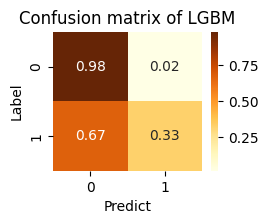

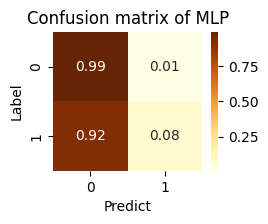

In [ ]:
def visualize_confusion_matrix(y_true,
                               pred_label,
                               height=.6,
                               labels=None,
                               title="defalut"):  # from https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 2, size * 1.5))
    sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')
    # „Çø„Ç§„Éà„É´„ÇíËøΩÂä†
    ax.set_title(title)

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    return fig

oof_label = np.where(oof > 0.5, 1, 0)
# SVC„ÅÆÊ∑∑ÂêåË°åÂàó„ÇíÂèØË¶ñÂåñ
fig = visualize_confusion_matrix(y_true=target_val, pred_label=oof_label, title="Confusion matrix of LGBM")
fig.show()
if is_do_mlp_and_svc:
    fig = visualize_confusion_matrix(y_true=target_val, pred_label=oof_mlp.argmax(1), title="Confusion matrix of MLP")
    fig.show()
    fig = visualize_confusion_matrix(y_true=target_val, pred_label=oof_svc.argmax(1), title="Confusion matrix of MLP")
    fig.show()


In [ ]:
print(predictions)
df_submission = pd.concat([df_test["id"], pd.DataFrame(predictions)], axis=1)
df_submission.to_csv("submission.csv", header=None, index=False)
if is_do_mlp_and_svc:
    df_submission_mlp = pd.concat([df_test["id"], pd.DataFrame(predictions_mlp)], axis=1)
    df_submission_svc = pd.concat([df_test["id"], pd.DataFrame(predictions_svc)], axis=1)
    # df_submission_ansamble = pd.concat(df_test["id"], pd.DataFrame(predictions_final, axis=1))

    # make submission file
    df_submission_mlp.to_csv("submission_mlp.csv", header=None, index=False)
    df_submission_svc.to_csv("submission_svc.csv", header=None, index=False)
    # df_submission_ansamble.to_csv("submission_knn_lgbm_mlp_ansamble.csv", header=None, index=False)




[0.08872698 0.1861361  0.20928395 ... 0.65073439 0.16171776 0.01908726]


LGBM


SVC


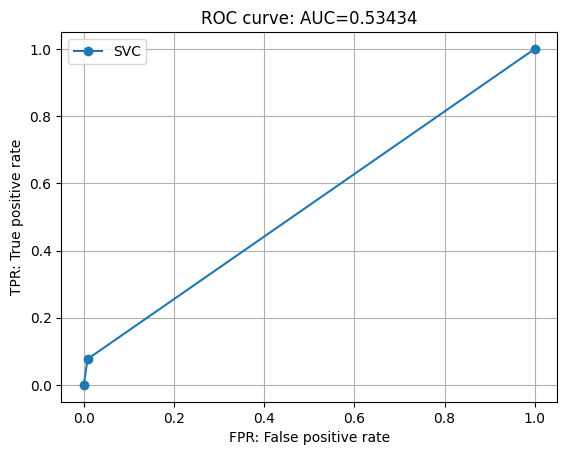

MLP


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr_all_lgb, tpr_all_lgb, thresholds_all_lgb = roc_curve(target_val, oof,
                                             drop_intermediate=False)

fpr_all_svc, tpr_all_svc, thresholds_all_svc = roc_curve(target_val, oof_svc.argmax(1),
                                             drop_intermediate=False)

fpr_all_mlp, tpr_all_mlp, thresholds_all_mlp = roc_curve(target_val, oof_mlp.argmax(1),
                                             drop_intermediate=False)

def visual_auc(fpr, tpr, thresholds, name,oof):

    plt.plot(fpr, tpr, marker='o', label=name)
    plt.xlabel('FPR: False positive rate')
    plt.ylabel('TPR: True positive rate')
    plt.grid()
    # auc„ÇíÊ±Ç„ÇÅ„Å¶Âõ≥„Å´ËøΩÂä†
    if name == "LGBM":
        auc = roc_auc_score(target_val, oof)
    else:
        auc = roc_auc_score(target_val, oof.argmax(1))
    plt.title(f'ROC curve: AUC={auc:.5f}')
    plt.legend()
    plt.show()

print("LGBM")
visual_auc(fpr_all_lgb, tpr_all_lgb, thresholds_all_lgb, "LGBM",oof)
print("SVC")
visual_auc(fpr_all_svc, tpr_all_svc, thresholds_all_svc, "SVC",oof_svc)
print("MLP")
visual_auc(fpr_all_mlp, tpr_all_mlp, thresholds_all_mlp, "MLP",oof_mlp)
